# **Fashion Style Generation: Evolutionary Search with Gaussian Mixture Models in the Latent Space** - Main Algorithm

This is the code for our paper presented at the EvoStar/EvoMUSART conference 2022.

Find the github repository here: https://github.com/imkegrabe/fashionstyle-generation-GMM/

We apply a Gaussian Mixture Model that is trained to distinguish between fashion styles to steer a Generative Adversarial Network (GAN) via the evolutionary loop displayed in the figure below:

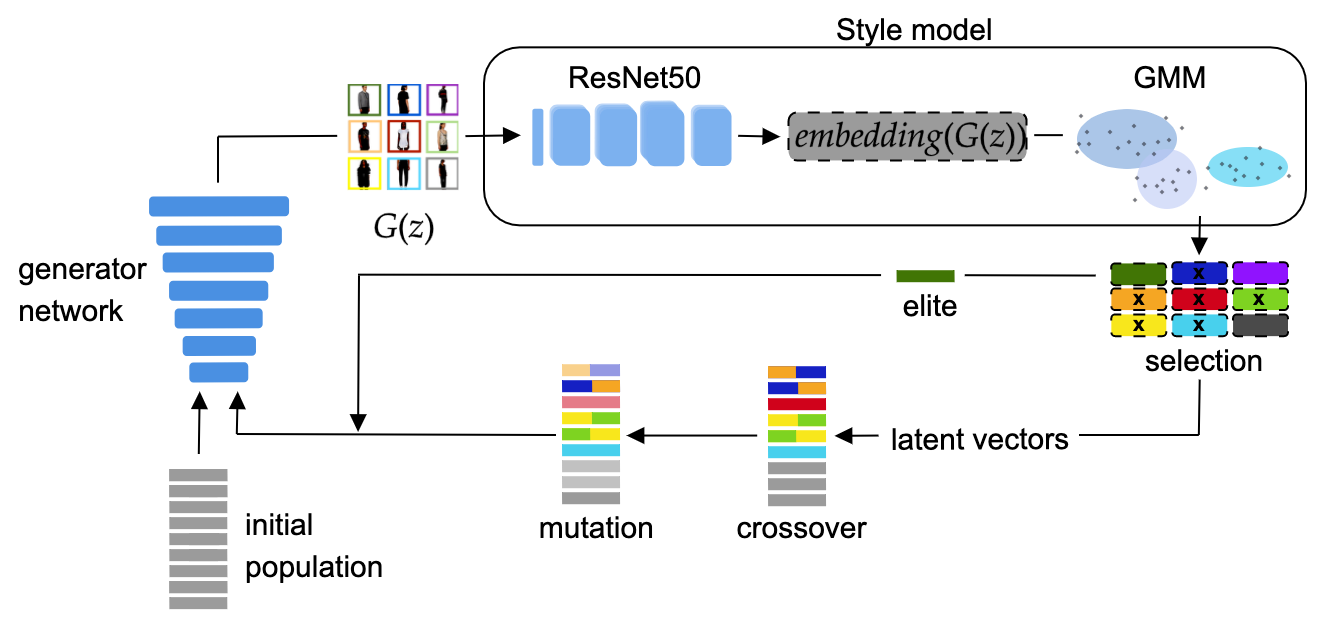

#**Set-up**
To run the code in Google Colab, download the content in this folder: https://drive.google.com/drive/folders/1TyMeCahYcZRf_VWxp8FSZrMTnE8BW2h_?usp=sharing
and save it in this path: **/content/drive/MyDrive/fashionstyle-generation-GMM/**
You might also want to download and save the FashionGen in a subfolder **/dataset**, however, that's not needed to try out the algortihm with our pre-trained models.

In [ ]:
import torch
import torch.nn as nn
import torch.hub as hub
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
import random

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

1
Tesla K80


device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/fashionstyle-generation-GMM/

Mounted at /content/drive
/content/drive/MyDrive/fashionstyle-generation-GMM


In [ ]:
%ls

FashionGen_s6_i96000.pt               pose4-index2-unique.pickle
gmm-nonorm-centonly-135pca-150kdiag/  README.md
images/                               resnet50_adjusted.pth
LICENCE                               resnet.pt
master_model.ipynb                    results/
pose4-embedding-unique.pickle         style_model.ipynb


#**STYLE MODEL**
The style model, consisting of a ResNet50 and a GMM, is specified and trained in this additional notebook: https://colab.research.google.com/drive/1Vz25oI_Wb2vgfJJPXeXE0FkXS2VOUfpv?usp=sharing


The ResNet50 extracts the embedding for (generated) images. The GMM projects the embedding onto the cluster space to estimate how well an image represents a style.

Here we import the pre-trained ResNet and GMM.

**ResNet50**

In [ ]:
#defining resnet 50 model + state dict initialized randomly
model = models.resnet50(pretrained=False)
model.to(device)
sd = model.state_dict()

#loading the new state_dict to the model - remember - last fc layer is just a placeholder, hence cannot be used
model.load_state_dict(torch.load("resnet50_adjusted.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Function for creating the embedding of an image with the ResNet:

In [ ]:
#functions to transform image to tensor, normalize, and scale
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#function to convert one image to feature vector
def extractembedding(image): #e.g. data[0]
  #convert image to tensor
  img = normalize(image.to(device))
  img.cpu()
  #print(img.is_cuda)
  
  #choose layer
  layer = model._modules.get('avgpool')

  #create empty feature vector
  feature_vector = torch.zeros(2048)

  #function that copies layer output into the feature vector
  def copy_data(m, i, o):
    feature_vector.copy_(o.flatten())
  
  #adding copy function to the layer
  h = layer.register_forward_hook(copy_data)

  #do it
  with torch.no_grad():
    model(img)
  h.remove()

  return feature_vector
#extractembedding(genind1).shape

**GMM**

Then we import the GMM as part of the style model, as well as the scaler and PCA parameters we need for projeting the embedding (of a generated image) onto the cluster space.

In [ ]:
#LOADING ALL MODELS AND PARAMS
instance = "gmm-nonorm-centonly-135pca-150kdiag"

#centerer for scaing generated images
with open('{}/scaler.pickle'.format(instance), 'rb') as handle:
  scaler = pickle.load(handle)

#PCA for projecting onto the PCA-space
with open('{}/pca.pickle'.format(instance), 'rb') as handle:
  pca_model = pickle.load(handle)

#GMM model
with open('{}/gmm.pickle'.format(instance), 'rb') as handle:
  clustering_model = pickle.load(handle)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator PCA from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at y

#**GAN MODEL**
We train the P-GAN implementation made available by Facebook Research: https://github.com/facebookresearch/pytorch_GAN_zoo

By progressively growing the layers, the model was trained on the Clothing partition of the [FashionGen dataset](https://fashion-gen.com/) (Rostamzadeh et al., 2018) up to a resolution of 256x256 pixels:

<figure>
<img src='https://github.com/imkegrabe/fashionstyle-generation-GMM/blob/main/images/gen-model.gif?raw=true' />
<figcaption>Progressively growing of the GAN: The image shows how the resolution of generated images increased by progressively growing the layers of the generator (left/blue) and discriminator (right/yellow).</figcaption>
</figure>

The trained model is saved as **FashionGen_s6_i96000.pt**, which we just have to load in the following.

In [ ]:
#initialize the model
gan_model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', force_reload=True,
                       pretrained=False)

Downloading: "https://github.com/facebookresearch/pytorch_GAN_zoo/archive/hub.zip" to /root/.cache/torch/hub/hub.zip


In [ ]:
#load trained checkpoints
gan_model.load_state_dict(torch.load('FashionGen_s6_i96000.pt'))

Average network found !


In [ ]:
#to generate a random image
'''
noise, _ = gan_model.buildNoiseData(1)
print(noise)
generated_images = gan_model.test(noise)
'''

'\nnoise, _ = gan_model.buildNoiseData(1)\nprint(noise)\ngenerated_images = gan_model.test(noise)\n'

#**GENETIC ALGORITHM**
The trained style model and GAN are connected in an evolutionary loop via a genetic algorithm, as displayed in the figure above. It's objective is to optimize a population of designs to represent a certain fashion style with the help of the style model.



In [ ]:
#for documentation on the DEAP framework, see here: https://deap.readthedocs.io/en/master/
!pip install deap
from deap import creator
from deap import base
from deap import tools

     |████████████████████████████████| 160 kB 4.9 MB/s 


In [ ]:
def genetic_algorithm(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA=False, PLOT=False):

  '''
  SET UP THE TOOLBOX
  '''

  toolbox = base.Toolbox()

  #POPULATION
  IND_SIZE = 532 #length of latent vectors + 20 placeholders required by the model
  creator.create("FitnessMax", base.Fitness, weights=(1.0,)) #maximizing objective
  creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)
  toolbox.register("attr_float", random.gauss, mu=0, sigma=1) #like the GAN's latent variables
  toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)
  
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  #function to evaluate fitness of an individual
  def evaluateInd(individual):
    new = torch.from_numpy(individual).unsqueeze(0)
    #generate the image
    genimage = gan_model.test(new.float(), getAvG=True)
    #get its embedding
    embedding = extractembedding(genimage)
    #get its probability of belonging to the target style after scaling and PCA
    scaled_embedding = scaler.transform((embedding.numpy()).reshape(1,-1))
    proj_embedding = pca_model.transform(scaled_embedding)
    target_proba = clustering_model.predict_proba(proj_embedding)[0,TC]
    return target_proba, #fitness weights should be in tuples

  toolbox.register("mate", tools.cxUniform, indpb =0.5)
  toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb =0.5)
  toolbox.register("select", tools.selTournament, tournsize=NTOUR, fit_attr='fitness')
  toolbox.register("evaluate", evaluateInd)

  '''
  AFTER SETTING UP THE TOOLBOX
  '''

  #initialize population and evaluate its fitness
  population = toolbox.population(NPOP)
  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  #to collect fittest images
  noice, _ = gan_model.buildNoiseData(1)
  collection_vectors = np.empty(noice.shape)

  #register stats
  stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats_size = tools.Statistics(key=len)
  mstats = tools.MultiStatistics(fitness = stats_fit,
                                 size = stats_size)
  mstats.register("avg", np.mean, axis=0)
  mstats.register("std", np.std, axis=0)
  mstats.register("min", np.min, axis=0)
  mstats.register("max", np.max, axis=0)
  logbook = tools.Logbook()

  for g in range(NGEN):

    if SIGMA: #for dynamic mutation
      toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=(1-g/NGEN), indpb=1) #SIGMA AS MUTBP

    #ELITE
    elite = tools.selBest(population, NELITE)
    elite = list(map(toolbox.clone, elite))

    #SELECTION
    offspring = toolbox.select(population, NPOP)
    offspring = list(map(toolbox.clone, offspring))

    #CROSSOVER
    for child1, child2 in zip(offspring[::2], reversed(offspring[1::2])):
      if random.random() < CXPB:
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values
    
    #NEW
    offspring.extend(toolbox.population(NNEW))

    #MUTATION
    for mutant in offspring:
      if random.random() < MUTPB:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    #and add the elite
    offspring.extend(elite)

    #EVAL NEW FITNESSES
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

    #REPLACE POPULATION WITH OFFSPRING
    population[:] = offspring

    #PLOT
    if PLOT==True and g % 10 == 0:
      tens = torch.from_numpy(np.asarray(population))
      genimgs = gan_model.test(tens.float(), getAvG=True)
      plt.figure(figsize=(20, 6), dpi=200)
      fig = plt.gcf()
      plt.imshow(torchvision.utils.make_grid(genimgs, nrow=25).permute(1, 2, 0).cpu().numpy())
      ax = plt.gca()
      ax.axes.xaxis.set_ticks([])
      ax.axes.yaxis.set_ticks([])
      plt.show()
      #fig.savefig('/runs/gen{}.png'.format(g))

    #COLLECTION to preserve the best individual per generation
    fittest = np.asarray(toolbox.clone(tools.selBest(population, 1)))
    fittest_tensor = torch.from_numpy(fittest)
    collection_vectors = np.append(collection_vectors, fittest, axis=0)
    
    #RECORD STATS
    record = mstats.compile(population)
    logbook.record(gen=g, evals=30, **record)

  collection_vectors = collection_vectors[1:]

  return logbook, collection_vectors, population
l, c, p = genetic_algorithm(CXPB=0.5, MUTPB=0.2, NGEN=150, NPOP=100, NTOUR=3, TC=96, NELITE=1, NNEW=7, SIGMA=False, PLOT=True)

#**Experiments**



Execution of experiments

Row of experiments

In [ ]:
CXPBS = [0.9]#[0.7, 0.9]
MUTPBS = [0.2]#[0.2, 0.5]
NGEN = 500
POPS = [200]
TOURS = [3]
TARGS = [72, 91, 105, 118, 135]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "final"

for CXPB in CXPBS:
  for MUTPB in MUTPBS:
    for NPOP in POPS:
      for NTOUR in TOURS:
        for TC in TARGS:
          print(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE)
          logbook, fitcollection, finalpop = genetic_algorithm(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA=False, PLOT=False)
      
      #SAVE LOGBOOK + COLLECTION
          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
            pickle.dump(logbook, handle)

          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-fitcollection.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
            pickle.dump(fitcollection, handle)

          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-finalpop.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
            pickle.dump(finalpop, handle)

0.9 0.2 500 200 3 72 1 5 False final


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


0.9 0.2 500 200 3 91 1 5 False final


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


0.9 0.2 500 200 3 105 1 5 False final


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


0.9 0.2 500 200 3 118 1 5 False final


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


0.9 0.2 500 200 3 135 1 5 False final


/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Single experiment

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


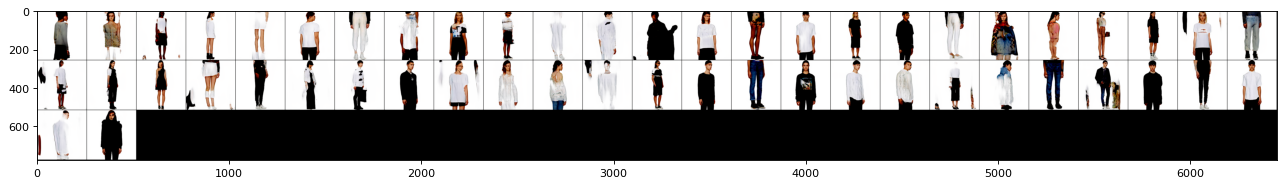

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


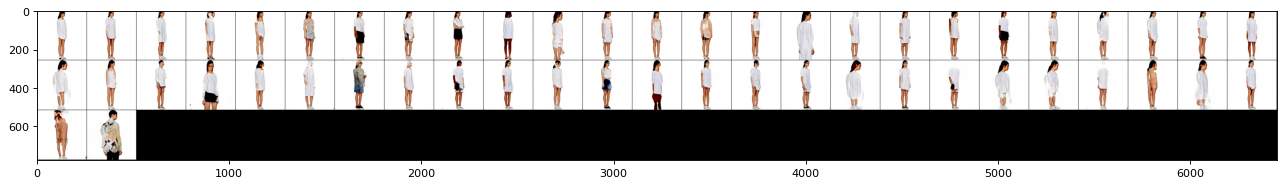

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


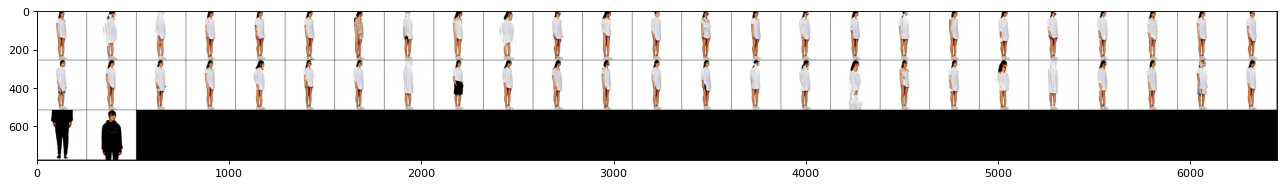

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


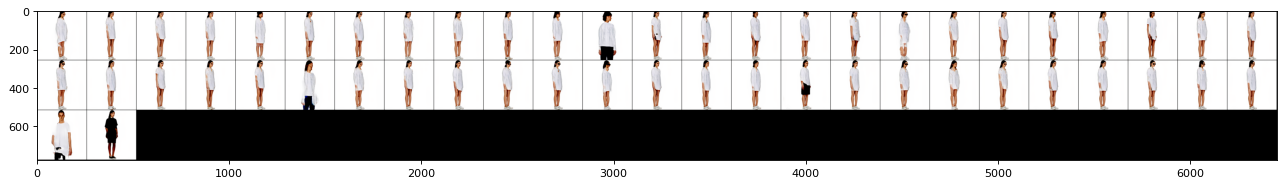

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


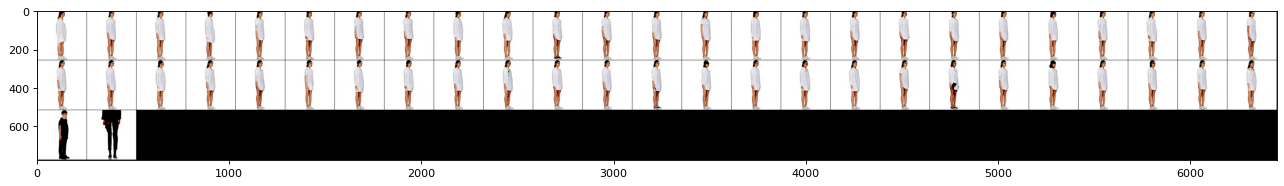

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


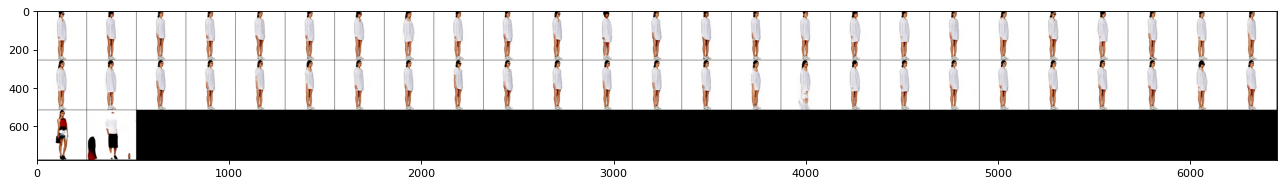

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


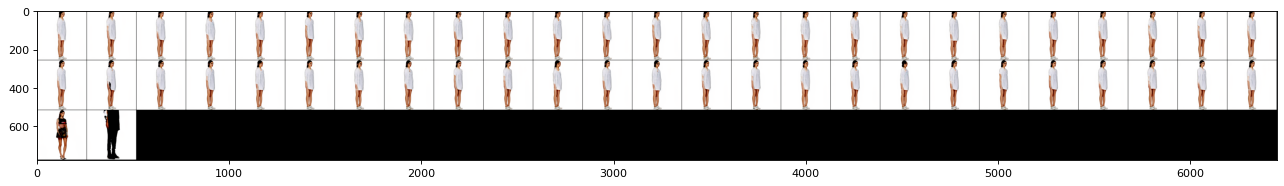

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


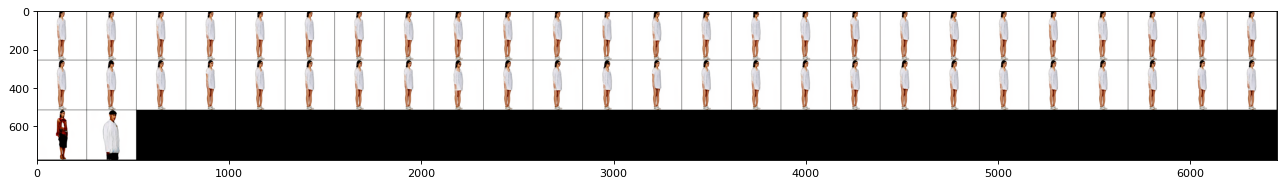

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


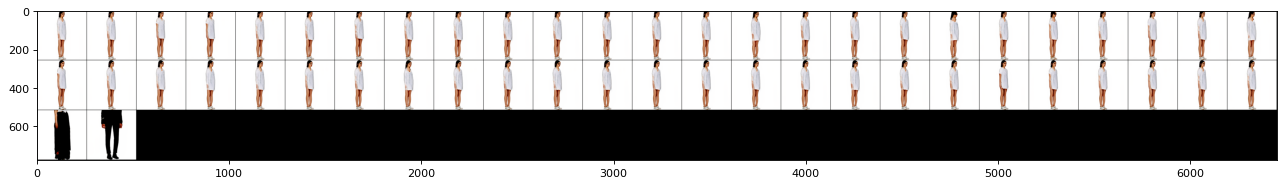

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


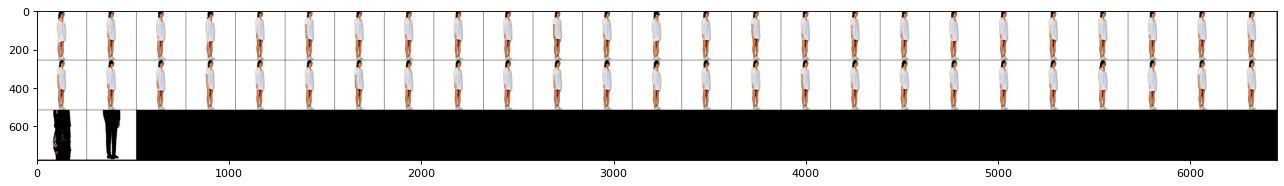

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


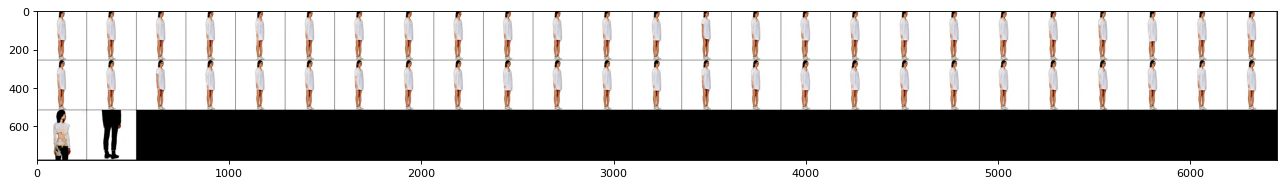

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


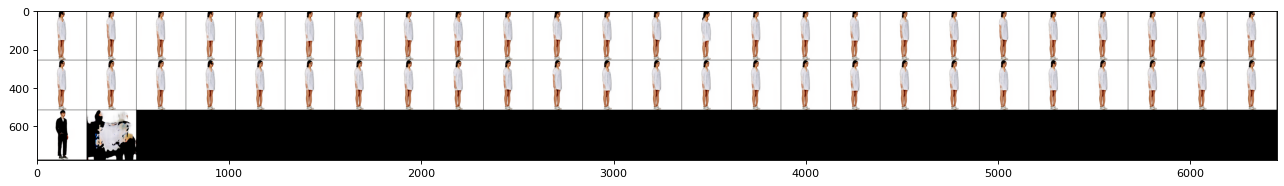

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


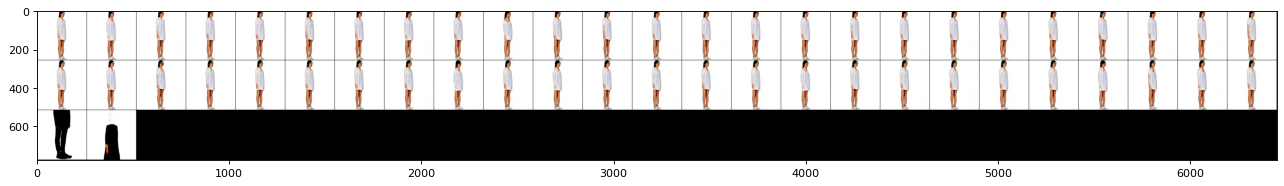

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


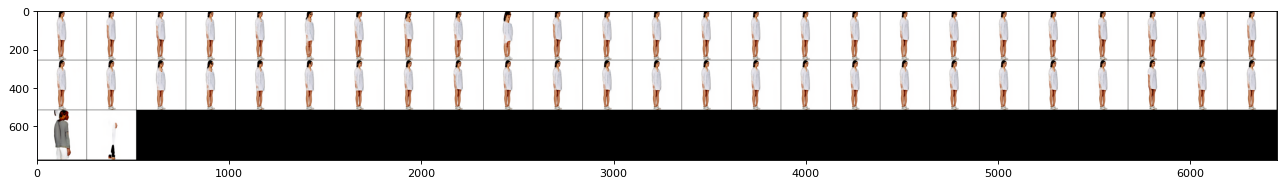

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


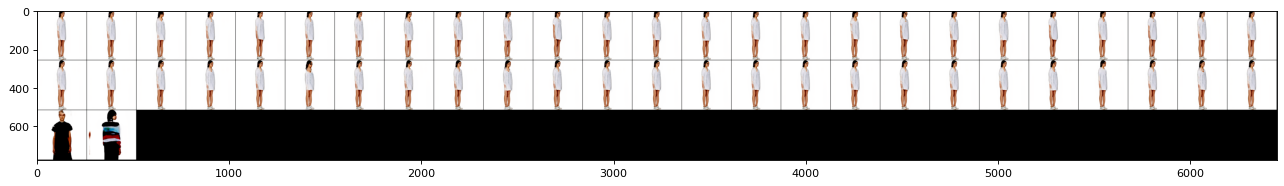

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


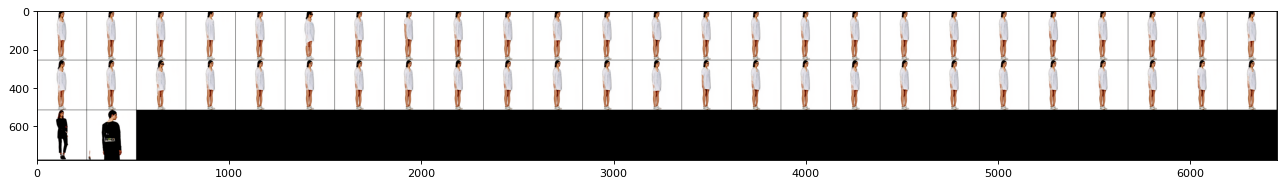

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


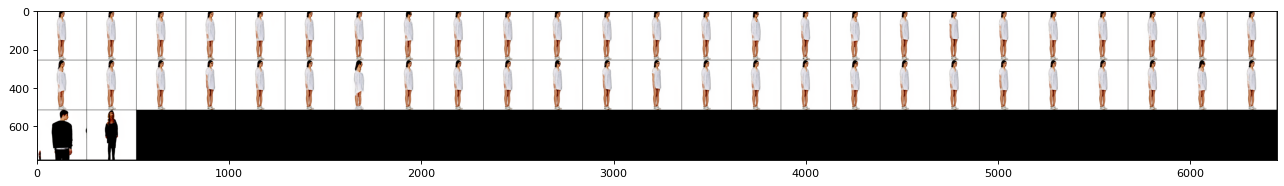

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


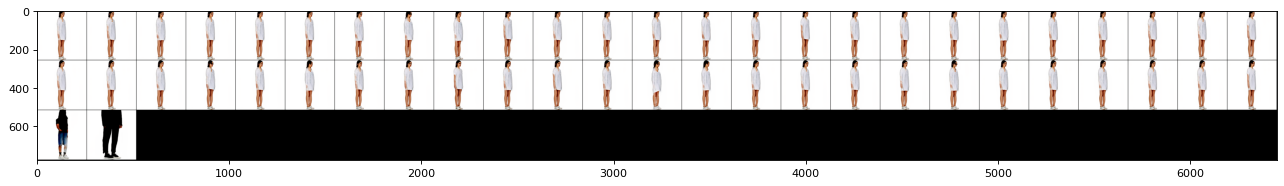

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


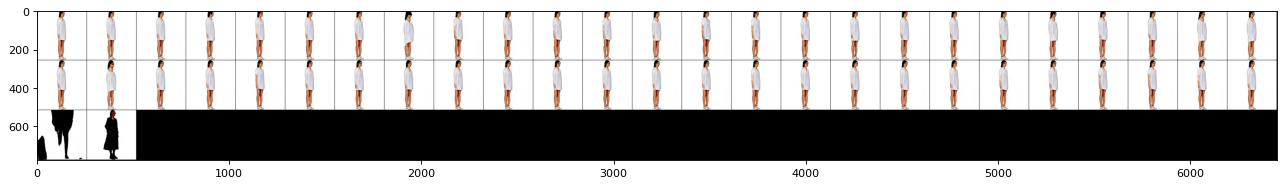

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


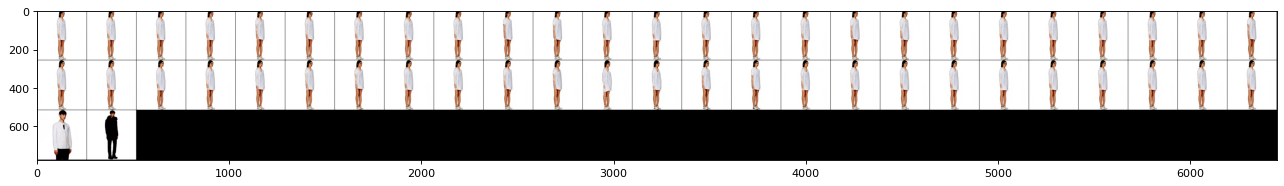

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


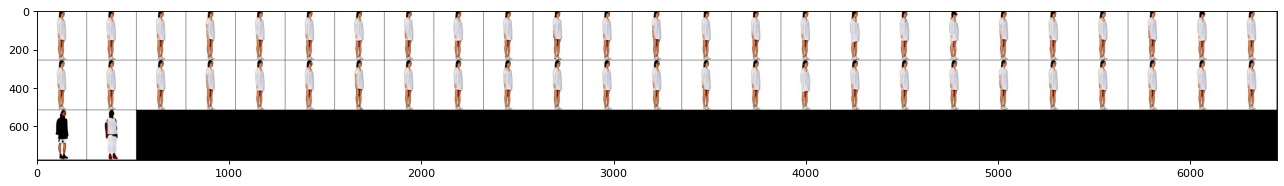

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


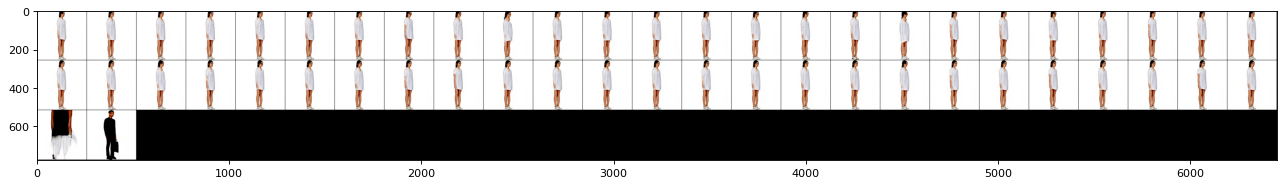

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


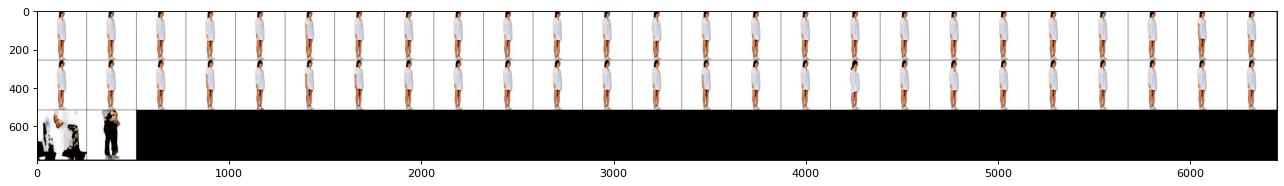

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


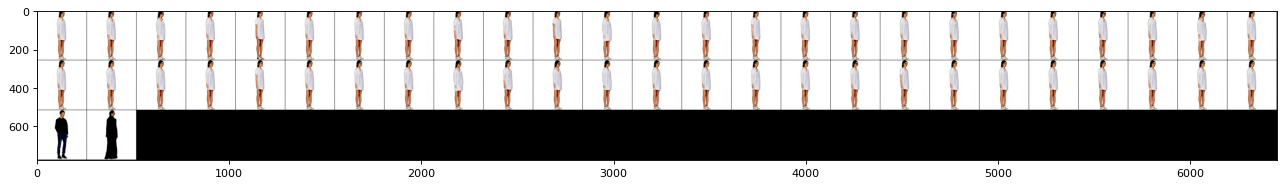

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


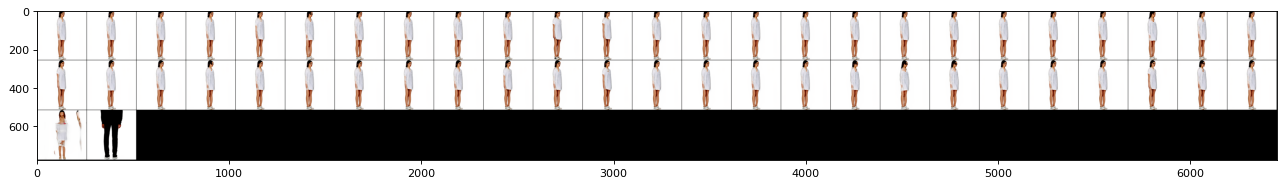

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


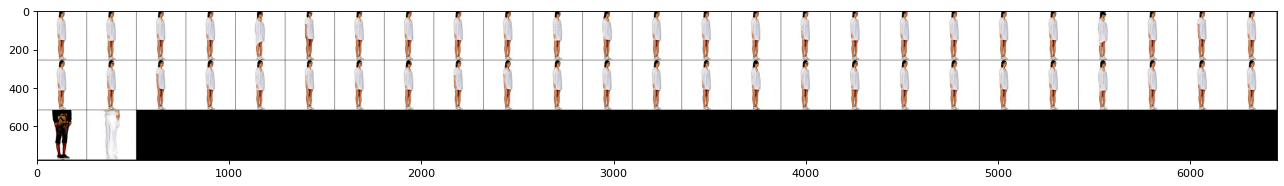

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


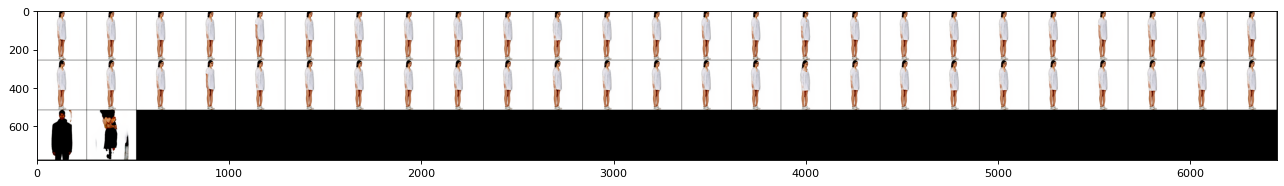

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


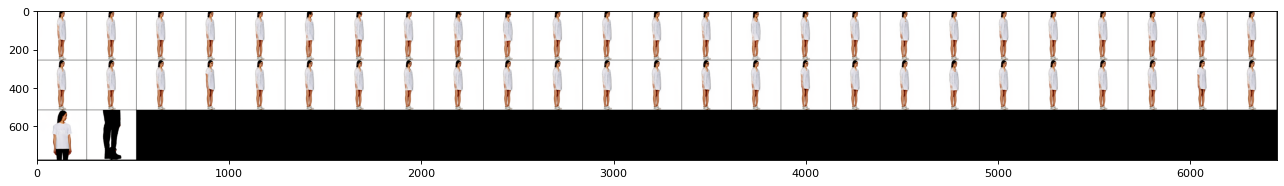

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


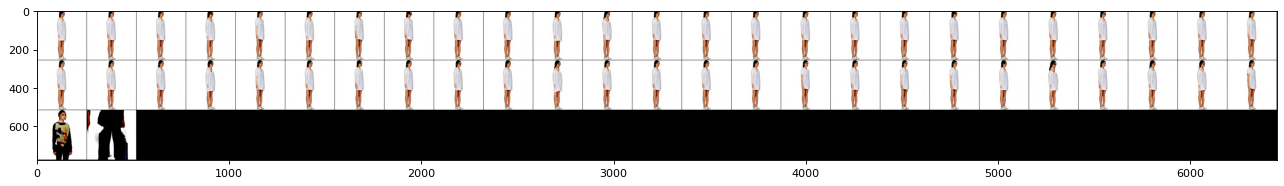

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


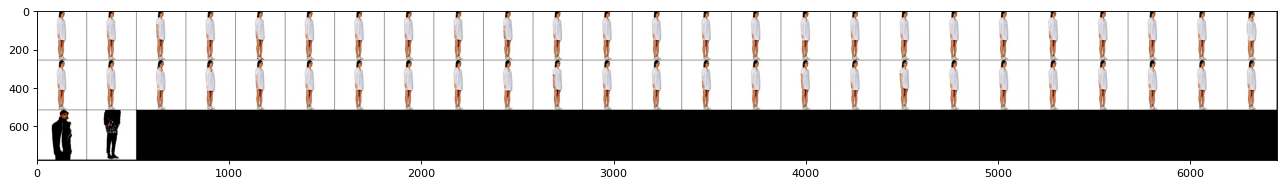

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


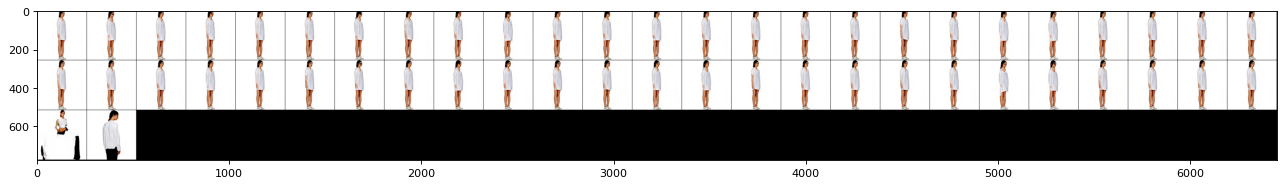

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


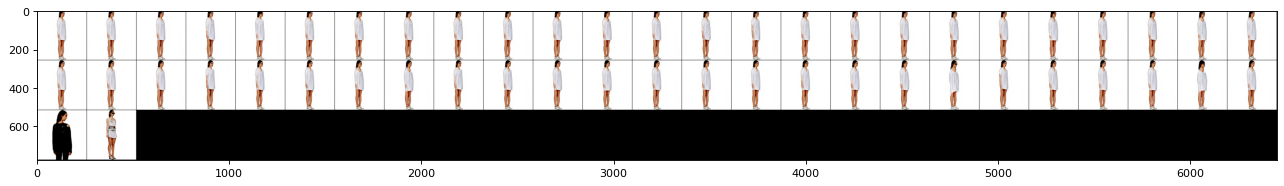

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


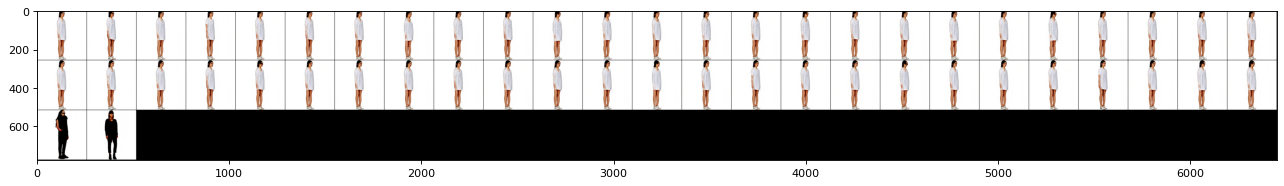

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


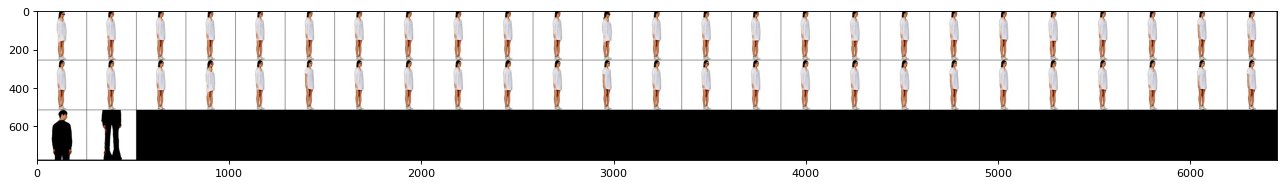

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


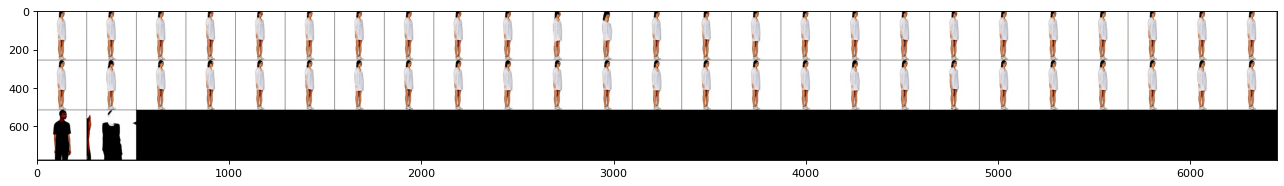

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


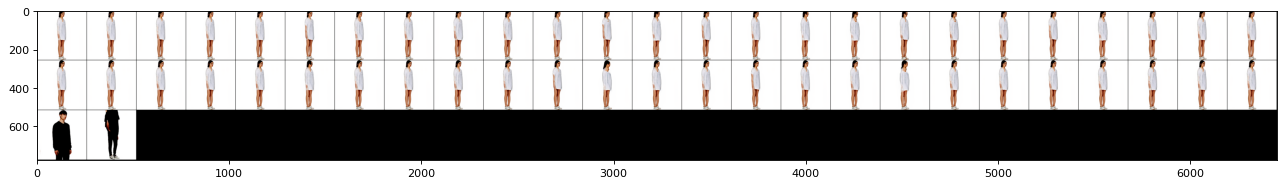

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


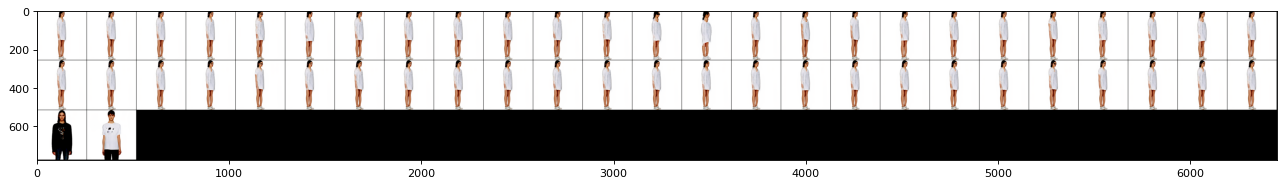

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


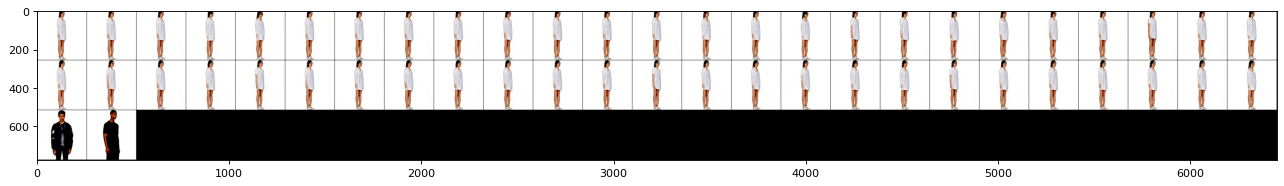

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


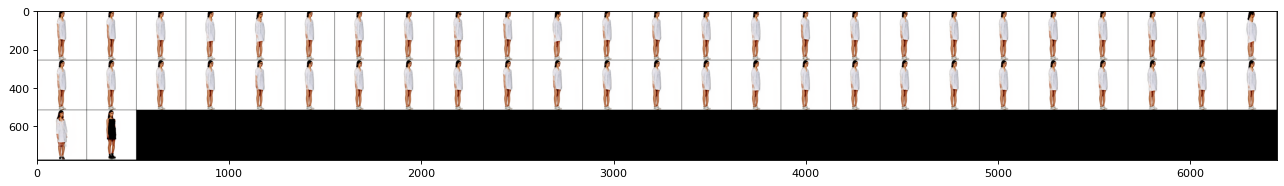

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


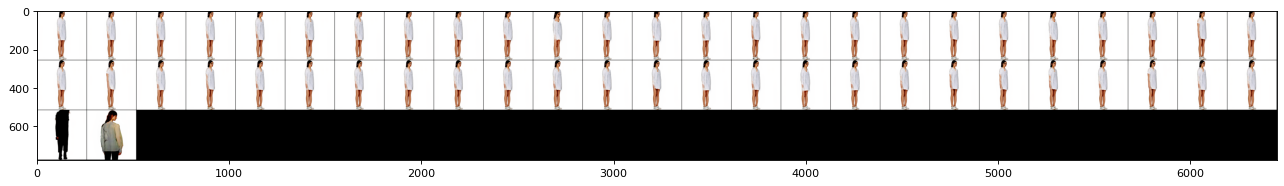

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


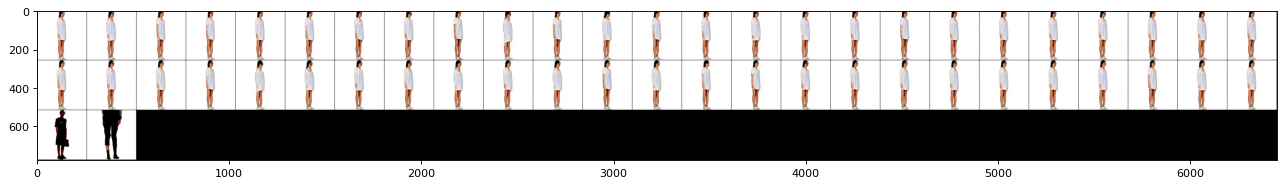

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


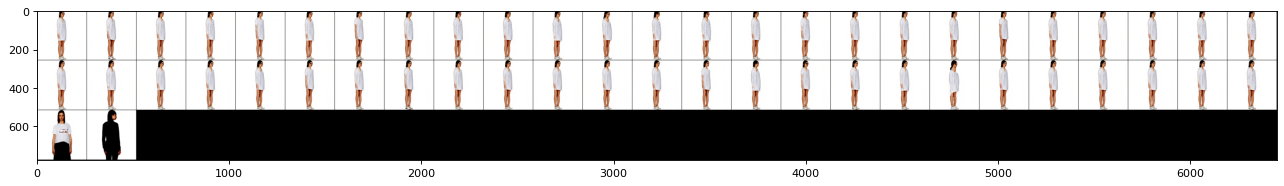

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


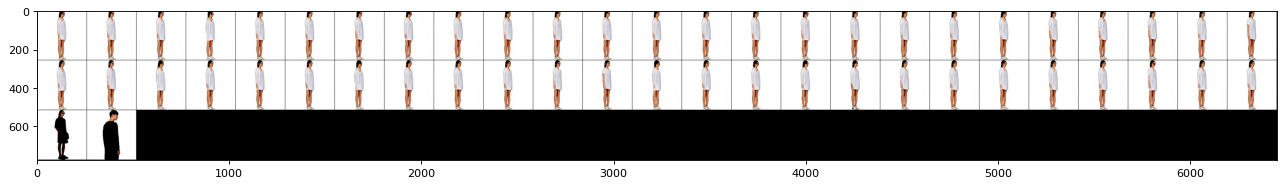

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


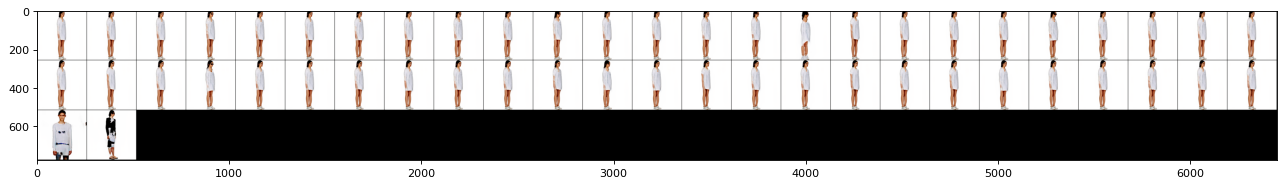

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


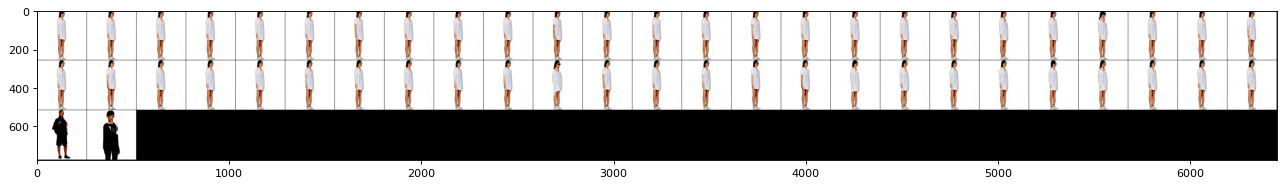

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


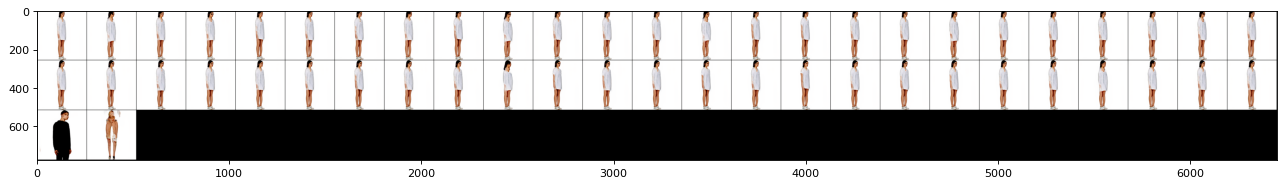

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


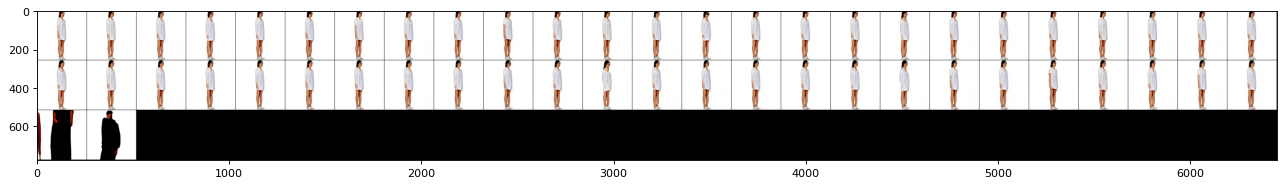

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


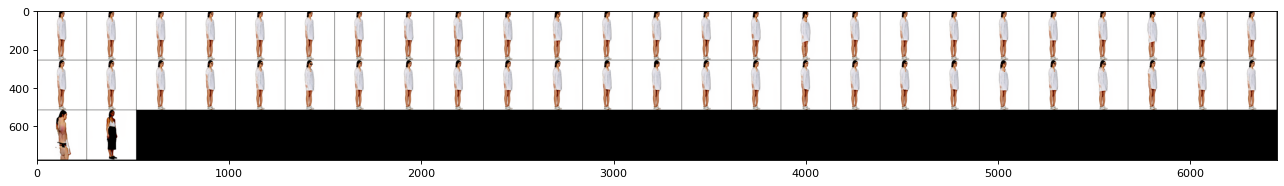

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


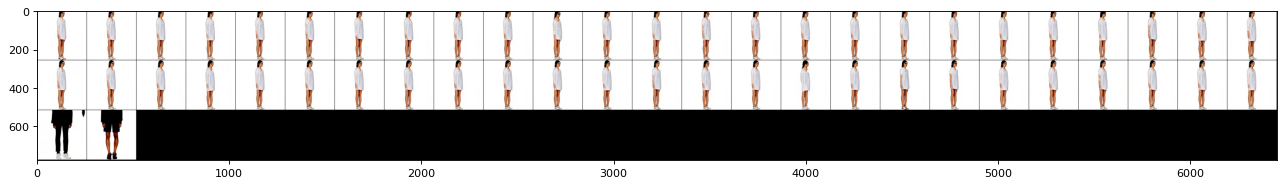

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


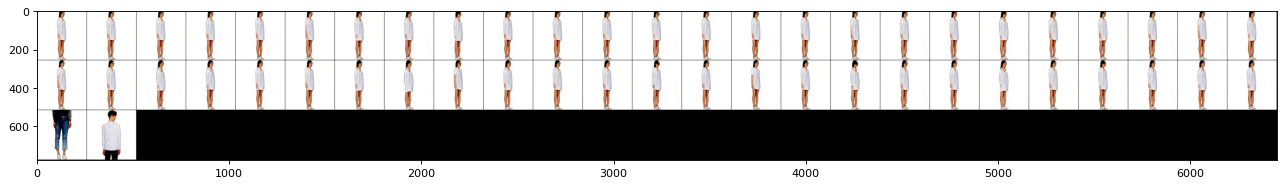

In [ ]:
CXPB = 0.9
MUTPB = 0.5
NGEN = 500
NPOP = 200
NTOUR = 6
TC = 138
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

logbook, fitcollection, finalpop = genetic_algorithm(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA=False, PLOT=True)
      
      #SAVE LOGBOOK + COLLECTION
with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
  pickle.dump(logbook, handle)

with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-fitcollection.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
  pickle.dump(fitcollection, handle)

with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-finalpop.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'wb') as handle:
  pickle.dump(finalpop, handle)

**Evaluation of experiments**
Making plots for each run, and collecting the best fitness averaged over all five runs under the same parameter combination

0.7 0.2 500 100 3 48 0.0004514931166957151


<Figure size 432x288 with 0 Axes>

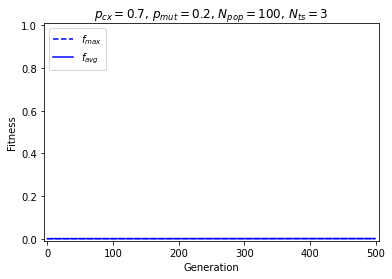

0.7 0.2 500 100 3 65 1.3801394379128666e-12


<Figure size 432x288 with 0 Axes>

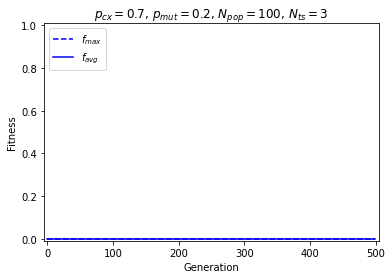

0.7 0.2 500 100 3 96 0.9999999995309281


<Figure size 432x288 with 0 Axes>

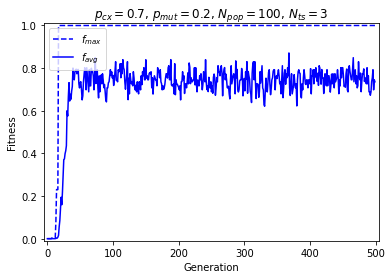

0.7 0.2 500 100 3 11 0.9669187047641069


<Figure size 432x288 with 0 Axes>

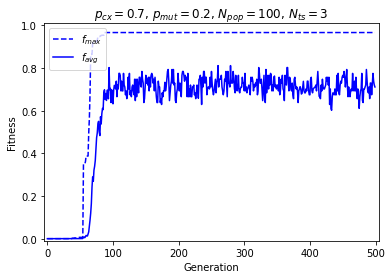

0.7 0.2 500 100 3 138 0.905532774776753


<Figure size 432x288 with 0 Axes>

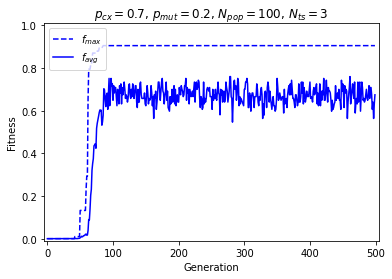

0.7 0.2 500 100 6 48 1.5538877281884595e-07


<Figure size 432x288 with 0 Axes>

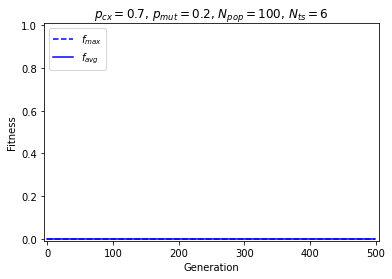

0.7 0.2 500 100 6 65 3.3430370404829386e-14


<Figure size 432x288 with 0 Axes>

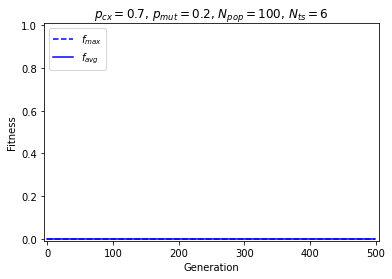

0.7 0.2 500 100 6 96 0.9999967276827385


<Figure size 432x288 with 0 Axes>

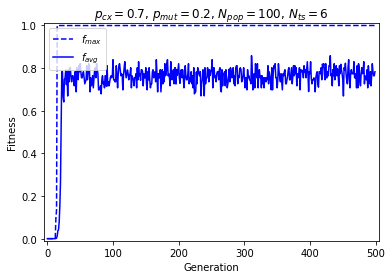

0.7 0.2 500 100 6 11 0.0001907554453061977


<Figure size 432x288 with 0 Axes>

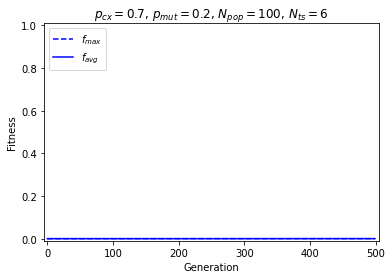

0.7 0.2 500 100 6 138 2.906023458541884e-08


<Figure size 432x288 with 0 Axes>

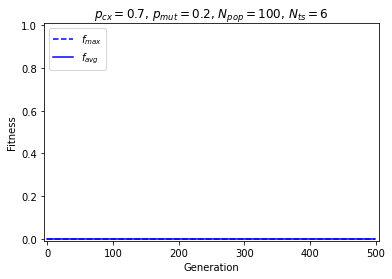

0.7 0.2 500 200 3 48 0.0012571193688406198


<Figure size 432x288 with 0 Axes>

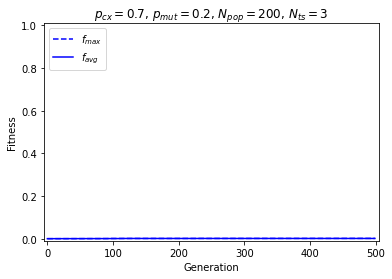

0.7 0.2 500 200 3 65 0.01865128122898521


<Figure size 432x288 with 0 Axes>

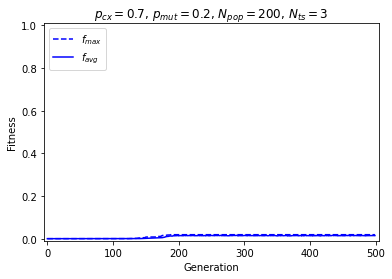

0.7 0.2 500 200 3 96 0.999999999999801


<Figure size 432x288 with 0 Axes>

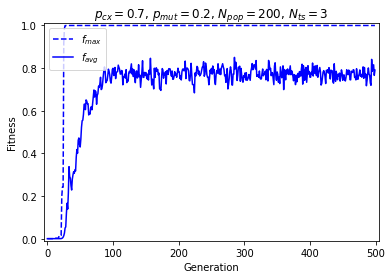

0.7 0.2 500 200 3 11 1.3875762793332905e-05


<Figure size 432x288 with 0 Axes>

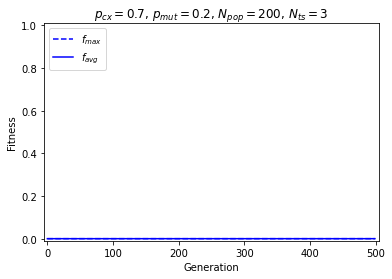

0.7 0.2 500 200 3 138 0.995673656427499


<Figure size 432x288 with 0 Axes>

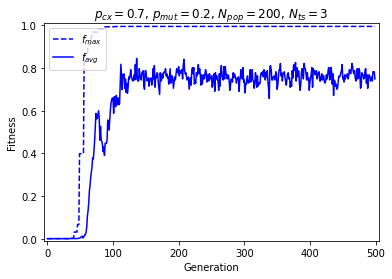

0.7 0.2 500 200 6 48 0.00021118415964366133


<Figure size 432x288 with 0 Axes>

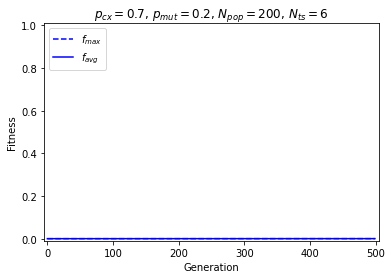

0.7 0.2 500 200 6 65 1.422865462606464e-10


<Figure size 432x288 with 0 Axes>

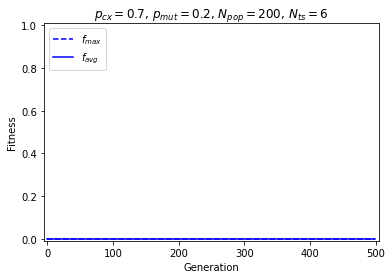

0.7 0.2 500 200 6 96 0.999999999589761


<Figure size 432x288 with 0 Axes>

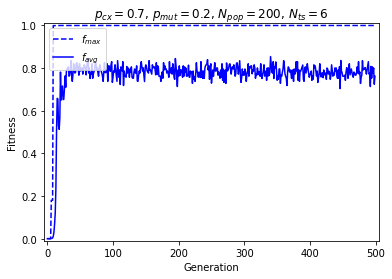

0.7 0.2 500 200 6 11 0.9999905767634274


<Figure size 432x288 with 0 Axes>

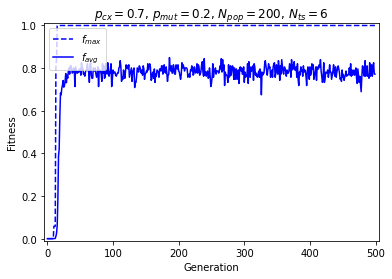

0.7 0.2 500 200 6 138 0.7450936861079889


<Figure size 432x288 with 0 Axes>

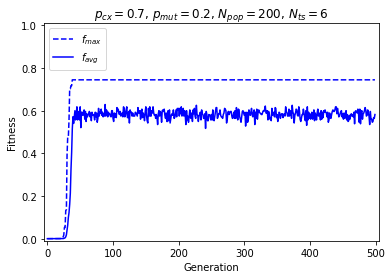

0.7 0.5 500 100 3 48 0.009305829233828422


<Figure size 432x288 with 0 Axes>

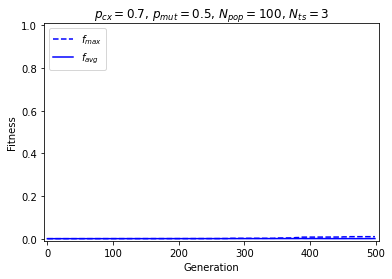

0.7 0.5 500 100 3 65 0.001042525321097093


<Figure size 432x288 with 0 Axes>

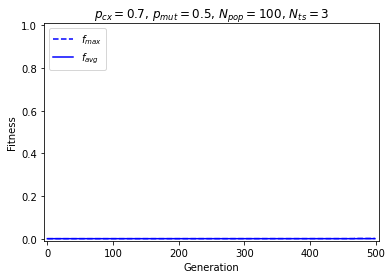

0.7 0.5 500 100 3 96 0.9999999999999574


<Figure size 432x288 with 0 Axes>

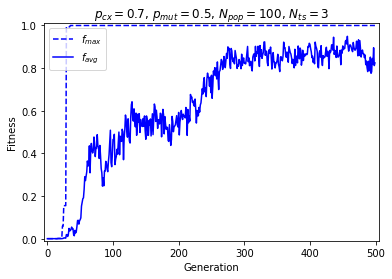

0.7 0.5 500 100 3 11 0.999942867472137


<Figure size 432x288 with 0 Axes>

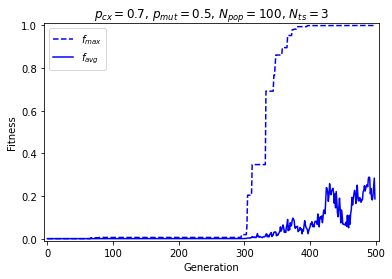

0.7 0.5 500 100 3 138 0.9999914861026924


<Figure size 432x288 with 0 Axes>

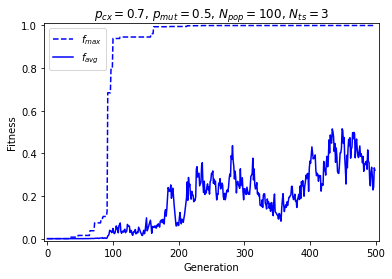

0.7 0.5 500 100 6 48 0.0006602986275209587


<Figure size 432x288 with 0 Axes>

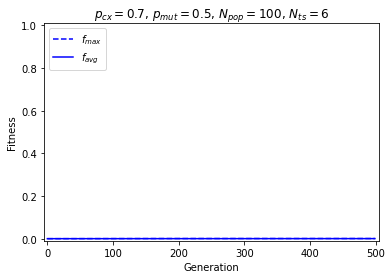

0.7 0.5 500 100 6 65 0.9999994287218141


<Figure size 432x288 with 0 Axes>

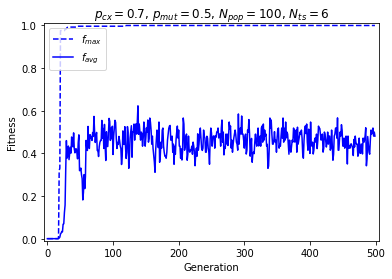

0.7 0.5 500 100 6 96 0.0008109390711344258


<Figure size 432x288 with 0 Axes>

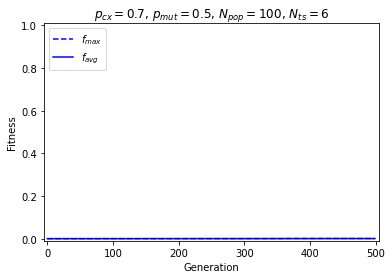

0.7 0.5 500 100 6 11 0.058098753129702335


<Figure size 432x288 with 0 Axes>

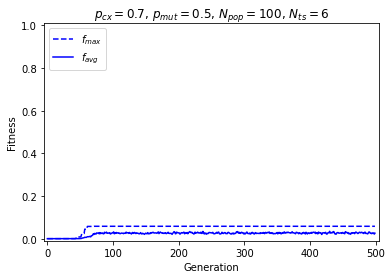

0.7 0.5 500 100 6 138 4.650348380356829e-05


<Figure size 432x288 with 0 Axes>

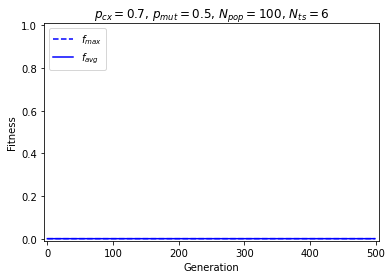

0.7 0.5 500 200 3 48 0.14773799867806056


<Figure size 432x288 with 0 Axes>

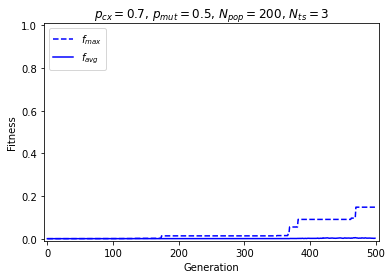

0.7 0.5 500 200 3 65 0.9973872022711782


<Figure size 432x288 with 0 Axes>

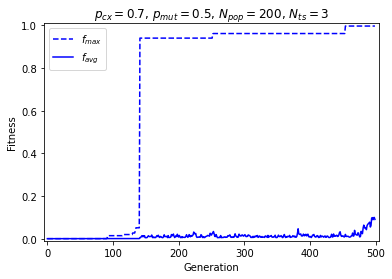

0.7 0.5 500 200 3 96 1.0


<Figure size 432x288 with 0 Axes>

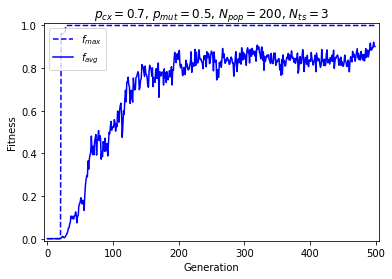

0.7 0.5 500 200 3 11 0.9995229984995154


<Figure size 432x288 with 0 Axes>

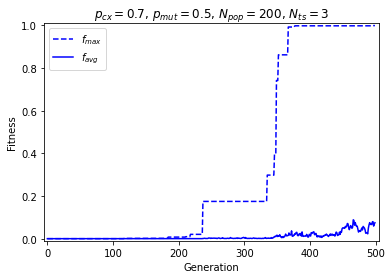

0.7 0.5 500 200 3 138 0.026083855118377377


<Figure size 432x288 with 0 Axes>

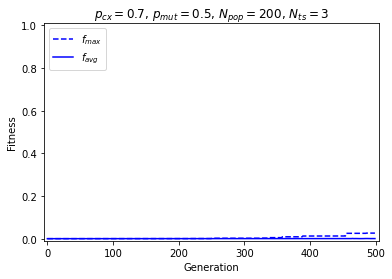

0.7 0.5 500 200 6 48 0.011401394161479407


<Figure size 432x288 with 0 Axes>

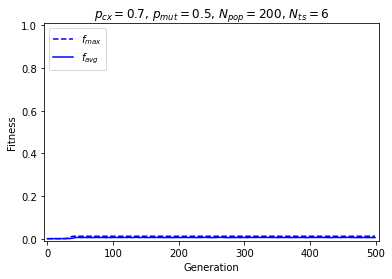

0.7 0.5 500 200 6 65 1.0688769855809462e-10


<Figure size 432x288 with 0 Axes>

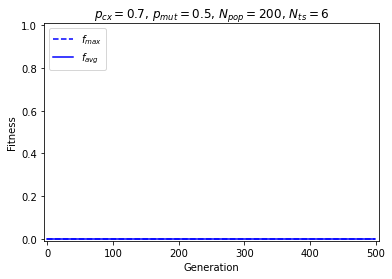

0.7 0.5 500 200 6 96 0.9999999977786587


<Figure size 432x288 with 0 Axes>

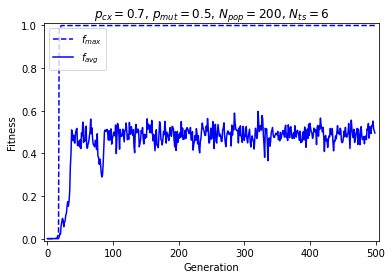

0.7 0.5 500 200 6 11 0.9995794112764255


<Figure size 432x288 with 0 Axes>

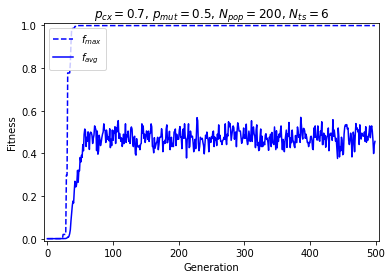

0.7 0.5 500 200 6 138 0.0031767885821259653


<Figure size 432x288 with 0 Axes>

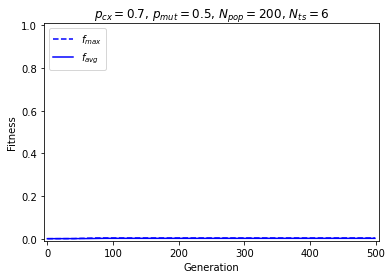

0.9 0.2 500 100 3 48 0.004298860215566047


<Figure size 432x288 with 0 Axes>

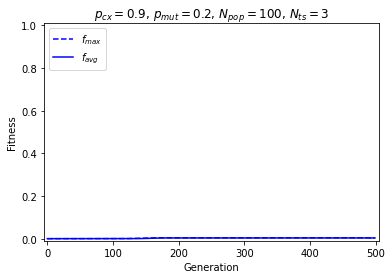

0.9 0.2 500 100 3 65 0.15260239507352086


<Figure size 432x288 with 0 Axes>

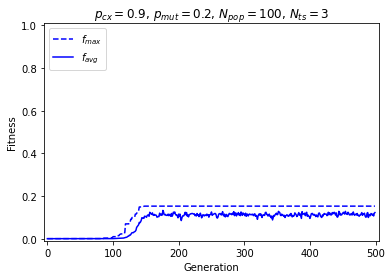

0.9 0.2 500 100 3 96 0.9999999999999858


<Figure size 432x288 with 0 Axes>

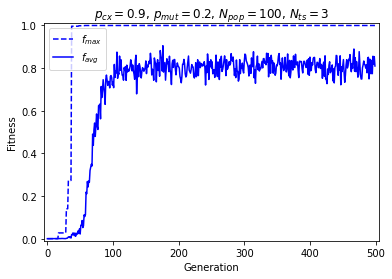

0.9 0.2 500 100 3 11 0.5020116279326792


<Figure size 432x288 with 0 Axes>

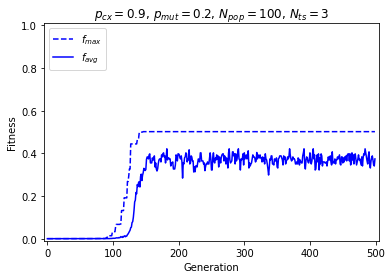

0.9 0.2 500 100 3 138 0.6101131254671092


<Figure size 432x288 with 0 Axes>

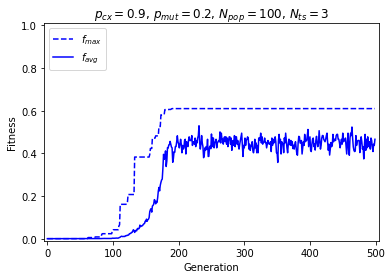

0.9 0.2 500 100 6 48 0.9268267352243518


<Figure size 432x288 with 0 Axes>

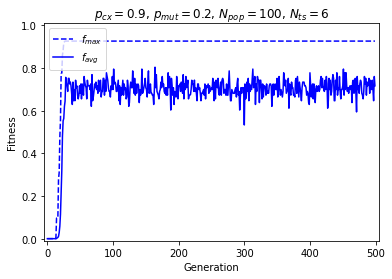

0.9 0.2 500 100 6 65 3.099449233469819e-11


<Figure size 432x288 with 0 Axes>

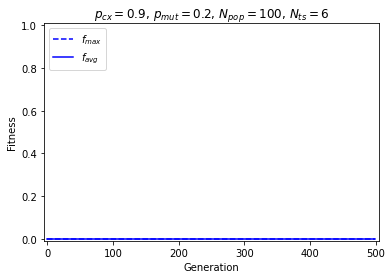

0.9 0.2 500 100 6 96 0.999999993287318


<Figure size 432x288 with 0 Axes>

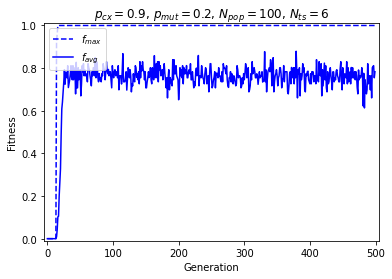

0.9 0.2 500 100 6 11 1.5117351545087747e-06


<Figure size 432x288 with 0 Axes>

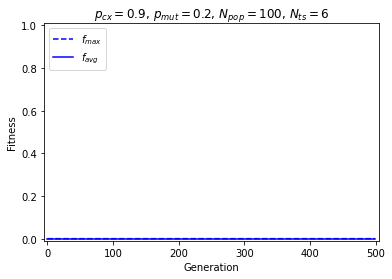

0.9 0.2 500 100 6 138 0.0008524632390099494


<Figure size 432x288 with 0 Axes>

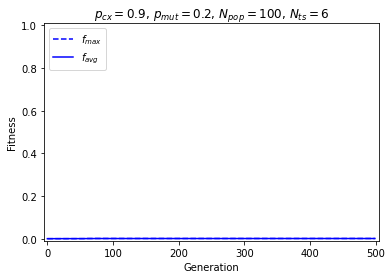

0.9 0.2 500 200 3 48 0.35544943930359424


<Figure size 432x288 with 0 Axes>

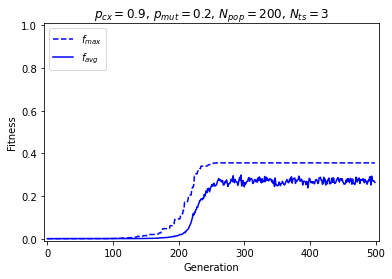

0.9 0.2 500 200 3 65 0.9999935333017241


<Figure size 432x288 with 0 Axes>

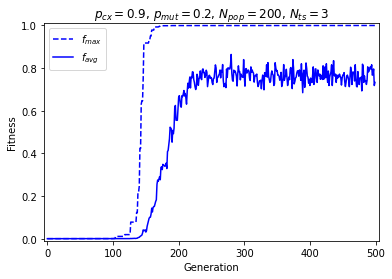

0.9 0.2 500 200 3 96 1.0


<Figure size 432x288 with 0 Axes>

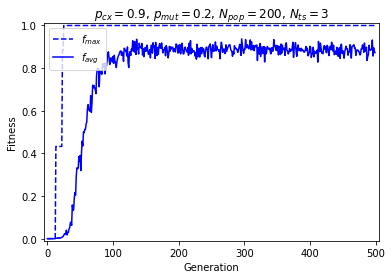

0.9 0.2 500 200 3 11 0.9957785510977181


<Figure size 432x288 with 0 Axes>

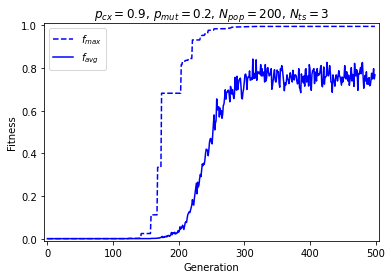

0.9 0.2 500 200 3 138 0.6853732565233165


<Figure size 432x288 with 0 Axes>

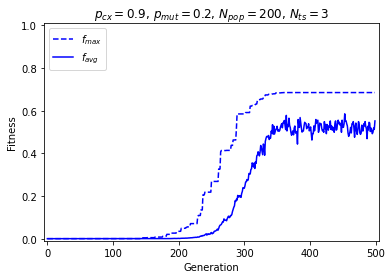

0.9 0.2 500 200 6 48 3.585769424631807e-08


<Figure size 432x288 with 0 Axes>

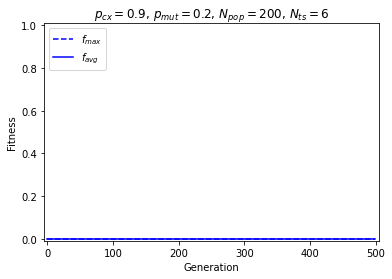

0.9 0.2 500 200 6 65 5.739191301433371e-15


<Figure size 432x288 with 0 Axes>

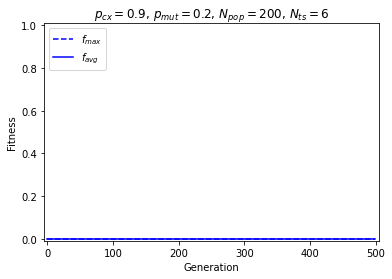

0.9 0.2 500 200 6 96 0.9999999983275671


<Figure size 432x288 with 0 Axes>

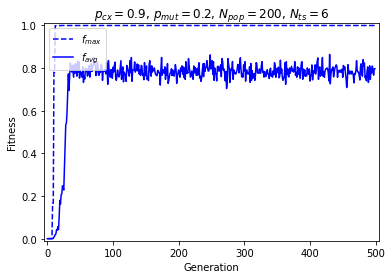

0.9 0.2 500 200 6 11 3.323941034841167e-05


<Figure size 432x288 with 0 Axes>

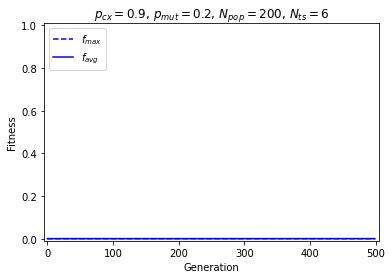

0.9 0.2 500 200 6 138 1.4785423377357653e-06


<Figure size 432x288 with 0 Axes>

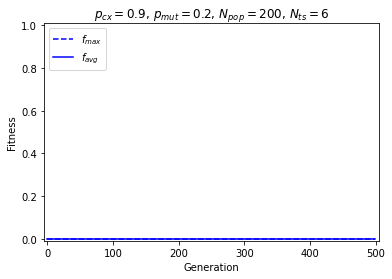

0.9 0.5 500 100 3 48 0.4286335755465689


<Figure size 432x288 with 0 Axes>

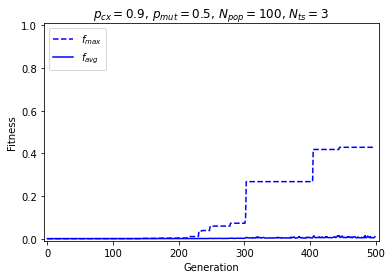

0.9 0.5 500 100 3 65 0.24699348184171882


<Figure size 432x288 with 0 Axes>

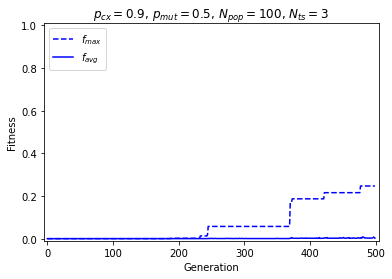

0.9 0.5 500 100 3 96 1.0


<Figure size 432x288 with 0 Axes>

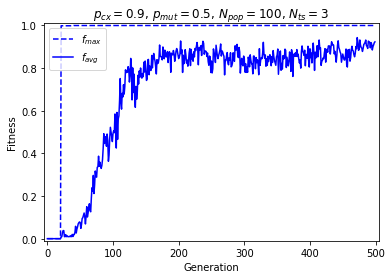

0.9 0.5 500 100 3 11 0.9999996942820998


<Figure size 432x288 with 0 Axes>

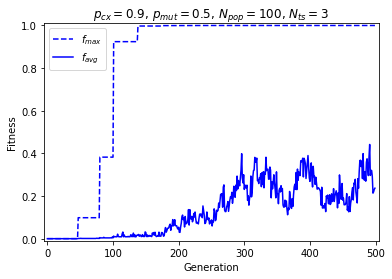

0.9 0.5 500 100 3 138 0.9993161802810936


<Figure size 432x288 with 0 Axes>

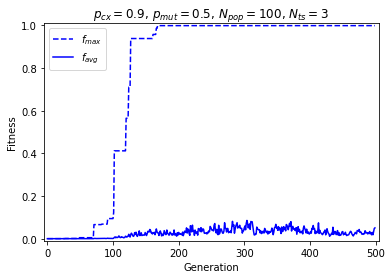

0.9 0.5 500 100 6 48 0.46755079913531067


<Figure size 432x288 with 0 Axes>

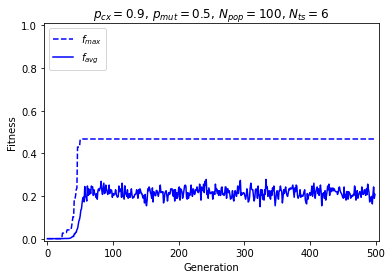

0.9 0.5 500 100 6 65 4.4443156522658765e-09


<Figure size 432x288 with 0 Axes>

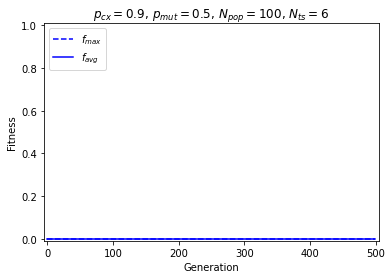

0.9 0.5 500 100 6 96 0.9999999999999432


<Figure size 432x288 with 0 Axes>

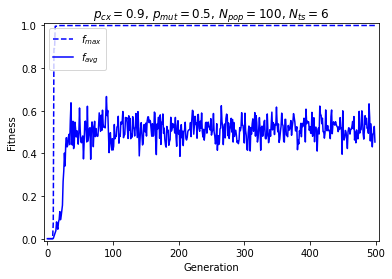

0.9 0.5 500 100 6 11 7.942349094584113e-06


<Figure size 432x288 with 0 Axes>

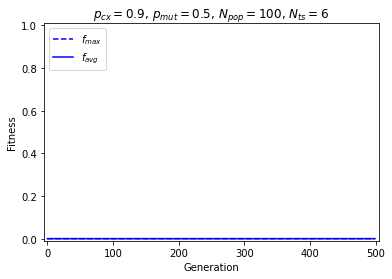

0.9 0.5 500 100 6 138 0.02341601828188403


<Figure size 432x288 with 0 Axes>

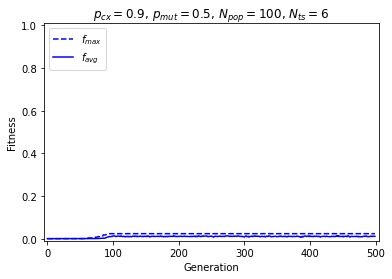

0.9 0.5 500 200 3 48 0.9999999812275464


<Figure size 432x288 with 0 Axes>

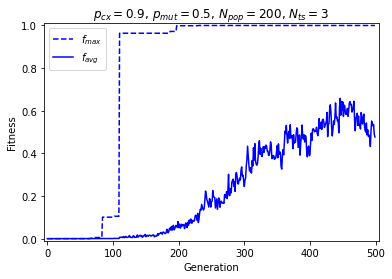

0.9 0.5 500 200 3 65 0.9350186857351769


<Figure size 432x288 with 0 Axes>

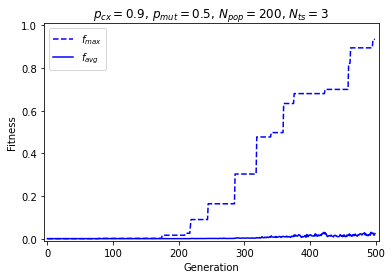

0.9 0.5 500 200 3 96 0.9999925895210732


<Figure size 432x288 with 0 Axes>

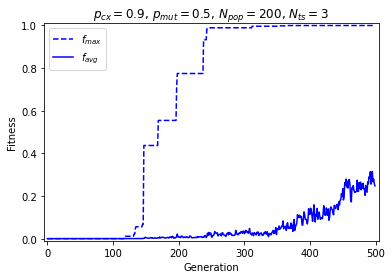

0.9 0.5 500 200 3 11 0.0505230152596314


<Figure size 432x288 with 0 Axes>

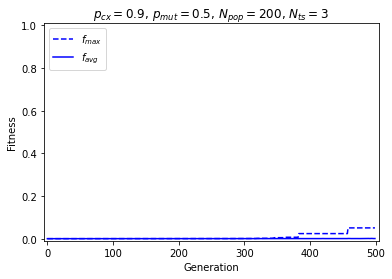

0.9 0.5 500 200 3 138 0.5358755264343994


<Figure size 432x288 with 0 Axes>

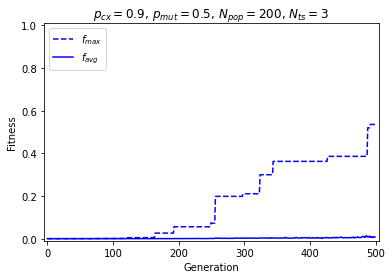

0.9 0.5 500 200 6 48 0.3038782883317513


<Figure size 432x288 with 0 Axes>

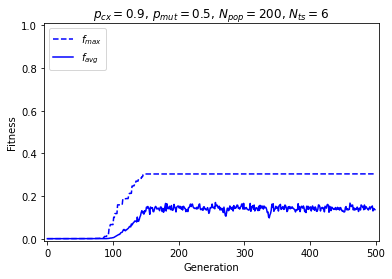

0.9 0.5 500 200 6 65 0.9731895547283954


<Figure size 432x288 with 0 Axes>

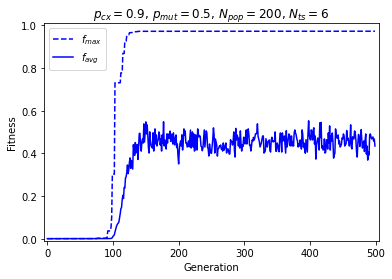

0.9 0.5 500 200 6 96 0.9999999978856096


<Figure size 432x288 with 0 Axes>

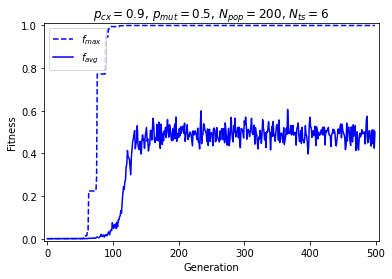

0.9 0.5 500 200 6 11 0.32386288866818963


<Figure size 432x288 with 0 Axes>

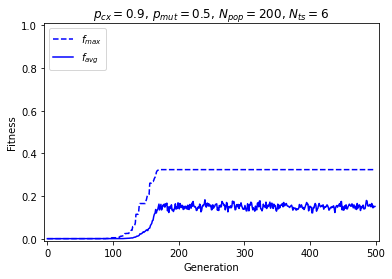

0.9 0.5 500 200 6 138 0.022852932633194767


<Figure size 432x288 with 0 Axes>

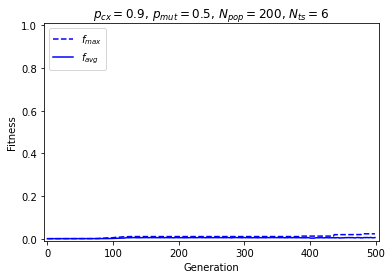

In [ ]:
CXPBS = [0.7, 0.9]
MUTPBS = [0.2, 0.5]
NGEN = 500
POPS = [100, 200]
TOURS = [3, 6]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

#array to collect the maximum fitness for all runs
best = np.empty((len(CXPBS), len(MUTPBS), len(POPS), len(TOURS), len(TARGS)))

for cx, CXPB in enumerate(CXPBS):
  for mut, MUTPB in enumerate(MUTPBS):
    for npo, NPOP in enumerate(POPS):
      for tz, NTOUR in enumerate(TOURS):
        for tk, TC in enumerate(TARGS):

          #OPEN LOGBOOK
          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
            logbook = pickle.load(handle)
          fit_max = logbook.chapters["fitness"].select("max")
          best[cx, mut, npo, tz, tk] = max(fit_max)

          print(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, best[cx, mut, npo, tz, tk])
          
          gen = logbook.select("gen")
          fit_avg = logbook.chapters["fitness"].select("avg")
          fig = plt.gcf()
          fig, ax1 = plt.subplots()
          line1 = ax1.plot(gen, fit_max, "b--", label="$f_{max}$")
          line2 = ax1.plot(gen, fit_avg, "b-", label="$f_{avg}$")

          #make legend
          lns = line1 + line2
          labs = [l.get_label() for l in lns]
          ax1.legend(lns,labs, loc="upper left")
          plt.ylim(-0.01, 1.01)
          plt.xlim(-5, 505)
          ax1.set_xlabel("Generation")
          ax1.set_ylabel("Fitness")
          plt.title(r"$p_{cx}=$" + str(CXPB) +", "+ r"$p_{mut}=$" + str(MUTPB) +", " + r"$N_{pop}=$" + str(NPOP) + ", " + r"$N_{ts}=$" + str(NTOUR) )
          plt.show()
          fig.savefig('results/plots/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=100)

In [ ]:
best.shape

(2, 2, 2, 2, 5)

In [ ]:
A = np.round(np.mean(best, axis=4), decimals=4)[1,1]
A

array([[0.735 , 0.2982],
       [0.7043, 0.5248]])

Aggregate for same parameter settings across clusters:

In [ ]:
aggr_best = np.empty((len(CXPBS), len(MUTPBS), len(POPS), len(TOURS)))
for cx, CXPB in enumerate(CXPBS):
  for mut, MUTPB in enumerate(MUTPBS):
    for npo, NPOP in enumerate(POPS):
      for tz, NTOUR in enumerate(TOURS):
        print(CXPB, MUTPB, NPOP, NTOUR, ":", np.mean(best[cx, mut, npo, tz]))
        aggr_best[cx, mut, npo, tz] = np.mean(best[cx, mut, npo, tz])
print(aggr_best)

0.7 0.2 100 3 : 0.5745805944379728
0.7 0.2 100 6 : 0.20003753351541712
0.7 0.2 200 3 : 0.40311918655758383
0.7 0.2 200 6 : 0.5490590893526215
0.7 0.5 100 3 : 0.6020565416259425
0.7 0.5 100 6 : 0.2119231846067951
0.7 0.5 200 3 : 0.6341464109134263
0.7 0.5 200 6 : 0.40283151838111547
0.9 0.2 100 3 : 0.45380520173777217
0.9 0.2 100 6 : 0.3855361407033658
0.9 0.2 200 3 : 0.8073189560452706
0.9 0.2 200 6 : 0.20000695042759062
0.9 0.5 100 3 : 0.7349885863902962
0.9 0.5 100 6 : 0.2981949528421096
0.9 0.5 200 3 : 0.7042819596355654
0.9 0.5 200 6 : 0.5247567324494282
[[[[0.57458059 0.20003753]
   [0.40311919 0.54905909]]

  [[0.60205654 0.21192318]
   [0.63414641 0.40283152]]]


 [[[0.4538052  0.38553614]
   [0.80731896 0.20000695]]

  [[0.73498859 0.29819495]
   [0.70428196 0.52475673]]]]


For MUTPB, CXPB, NPOP, TSIZE each, choose the parameter combination of the other three that performed best

In [ ]:
#axis order: [cx, mut, npo, tz]
print(np.mean(aggr_best, axis=0))

[[[0.5141929 ]
  [0.60521907]]

 [[0.66852256]
  [0.66921419]]]


**#Plot Graphs to Compare Parameter Values**

PLOT GRAPHS TO COMPARE PARAMETER VALUES: MUTPB

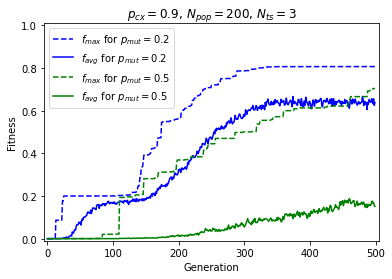

In [ ]:
CXPB = 0.9 # [0.7, 0.9]
MUTPBS = [0.2, 0.5]
NGEN = 500
NPOP = 200 #[100]
NTOUR = 3 #[3]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"


maxi = np.empty((2,5,500))
avgi = np.empty((2,5,500))

for mut, MUTPB in enumerate(MUTPBS):
  for tk, TC in enumerate(TARGS):
      #OPEN LOGBOOK
      with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
        logbook = pickle.load(handle)
      fit_max = logbook.chapters["fitness"].select("max")
      fit_avg = logbook.chapters["fitness"].select("avg")
      maxi[mut,tk] = fit_max
      avgi[mut,tk] = fit_avg
gen = logbook.select("gen")
maxi_avg = np.mean(maxi, axis=1)
avgi_avg = np.mean(avgi, axis=1)
maxi_avg[0]

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, maxi_avg[0], "b--", label="$f_{max}$ for $p_{mut}=0.2$")
line2 = ax1.plot(gen, avgi_avg[0], "b-", label="$f_{avg}$ for $p_{mut}=0.2$")
line3 = ax1.plot(gen, maxi_avg[1], "g--", label="$f_{max}$ for $p_{mut}=0.5$")
line4 = ax1.plot(gen, avgi_avg[1], "g-", label="$f_{avg}$ for $p_{mut}=0.5$")

#make legend
fig = plt.gcf()
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs, loc="upper left")
plt.ylim(-0.01, 1.01)
plt.xlim(-5, 505)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
plt.title(r"$p_{cx}=$" + str(CXPB) + ", " + r"$N_{pop}=$" + str(NPOP) + ", " + r"$N_{ts}=$" + str(NTOUR) )
plt.show()
fig.savefig('results/plots/mutcomp_cxpb{}mutpb{}ngen{}npop{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=500)

PLOT GRAPHS TO COMPARE PARAMETER VALUES: CXPB

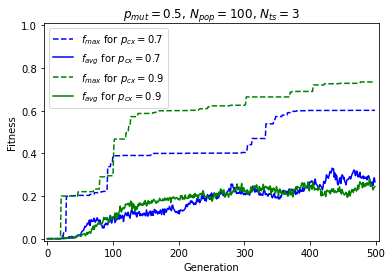

In [ ]:
CXPBS = [0.7, 0.9]
MUTPBS = 0.5 #[0.2, 0.5]
NGEN = 500
NPOP = 100 #[100]
NTOUR = 3 #[3]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

gen = logbook.select("gen")
maxi = np.empty((2,5,500))
avgi = np.empty((2,5,500))

for cx, CXPB in enumerate(CXPBS):
  for tk, TC in enumerate(TARGS):
      #OPEN LOGBOOK
      with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
        logbook = pickle.load(handle)
      fit_max = logbook.chapters["fitness"].select("max")
      fit_avg = logbook.chapters["fitness"].select("avg")
      maxi[cx,tk] = fit_max
      avgi[cx,tk] = fit_avg

maxi_avg = np.mean(maxi, axis=1)
avgi_avg = np.mean(avgi, axis=1)
maxi_avg[0]

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, maxi_avg[0], "b--", label="$f_{max}$ for $p_{cx}=0.7$")
line2 = ax1.plot(gen, avgi_avg[0], "b-", label="$f_{avg}$ for $p_{cx}=0.7$")
line3 = ax1.plot(gen, maxi_avg[1], "g--", label="$f_{max}$ for $p_{cx}=0.9$")
line4 = ax1.plot(gen, avgi_avg[1], "g-", label="$f_{avg}$ for $p_{cx}=0.9$")

#make legend
fig = plt.gcf()
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs, loc="upper left")
plt.ylim(-0.01, 1.01)
plt.xlim(-5, 505)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
plt.title(r"$p_{mut}=$" + str(MUTPB) +", " + r"$N_{pop}=$" + str(NPOP) + ", " + r"$N_{ts}=$" + str(NTOUR) )
plt.show()
fig.savefig('results/plots/cxcomp_cxpb{}mutpb{}ngen{}npop{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=500)

PLOT GRAPHS TO COMPARE PARAMETER VALUES: POPSIZE

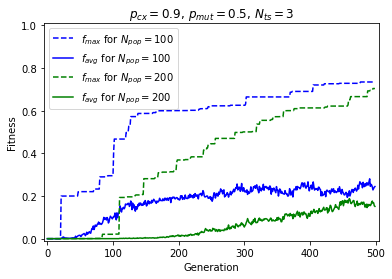

In [ ]:
CXPB = 0.9#[0.7, 0.9]
MUTPB = 0.5 #[0.2, 0.5]
NGEN = 500
NPOPS = [100, 200]
NTOUR = 3 #[3]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

maxi = np.empty((2,5,500))
avgi = np.empty((2,5,500))

for npo, NPOP in enumerate(NPOPS):
  for tk, TC in enumerate(TARGS):
      #OPEN LOGBOOK
      with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
        logbook = pickle.load(handle)
      gen = logbook.select("gen")
      fit_max = logbook.chapters["fitness"].select("max")
      fit_avg = logbook.chapters["fitness"].select("avg")
      maxi[npo,tk] = fit_max
      avgi[npo,tk] = fit_avg

maxi_avg = np.mean(maxi, axis=1)
avgi_avg = np.mean(avgi, axis=1)
maxi_avg[0]

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, maxi_avg[0], "b--", label="$f_{max}$ for $N_{pop}=100$")
line2 = ax1.plot(gen, avgi_avg[0], "b-", label="$f_{avg}$ for $N_{pop}=100$")
line3 = ax1.plot(gen, maxi_avg[1], "g--", label="$f_{max}$ for $N_{pop}=200$")
line4 = ax1.plot(gen, avgi_avg[1], "g-", label="$f_{avg}$ for $N_{pop}=200$")

#make legend
fig = plt.gcf()
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs, loc="upper left")
plt.ylim(-0.01, 1.01)
plt.xlim(-5, 505)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
plt.title(r"$p_{cx}=$" + str(CXPB) +", "+ r"$p_{mut}=$" + str(MUTPB) + ", " + r"$N_{ts}=$" + str(NTOUR) )
plt.show()
fig.savefig('results/plots/npopcomp_cxpb{}mutpb{}ngen{}npop{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=500)

PLOT GRAPHS TO COMPARE PARAMETER VALUES: TOURSIZE

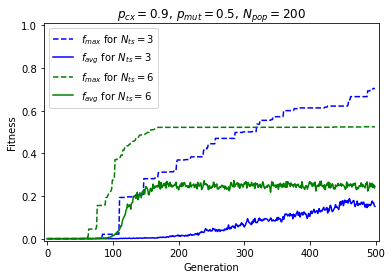

In [ ]:
CXPB = 0.9#[0.7, 0.9]
MUTPB = 0.5 #[0.2, 0.5]
NGEN = 500
NPOP = 200 #[100]
NTOURS = [3,6]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

gen = logbook.select("gen")
maxi = np.empty((2,5,500))
avgi = np.empty((2,5,500))

for nt, NTOUR in enumerate(NTOURS):
  for tk, TC in enumerate(TARGS):
      #OPEN LOGBOOK
      with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
        logbook = pickle.load(handle)
      fit_max = logbook.chapters["fitness"].select("max")
      fit_avg = logbook.chapters["fitness"].select("avg")
      maxi[nt,tk] = fit_max
      avgi[nt,tk] = fit_avg

maxi_avg = np.mean(maxi, axis=1)
avgi_avg = np.mean(avgi, axis=1)
maxi_avg[0]

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, maxi_avg[0], "b--", label="$f_{max}$ for $N_{ts}=3$")
line2 = ax1.plot(gen, avgi_avg[0], "b-", label="$f_{avg}$ for $N_{ts}=3$")
line3 = ax1.plot(gen, maxi_avg[1], "g--", label="$f_{max}$ for $N_{ts}=6$")
line4 = ax1.plot(gen, avgi_avg[1], "g-", label="$f_{avg}$ for $N_{ts}=6$")

#make legend
fig = plt.gcf()
lns = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lns]
ax1.legend(lns,labs, loc="upper left")
plt.ylim(-0.01, 1.01)
plt.xlim(-5, 505)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
plt.title(r"$p_{cx}=$" + str(CXPB) +", "+ r"$p_{mut}=$" + str(MUTPB) +", " + r"$N_{pop}=$" + str(NPOP) )
plt.show()
fig.savefig('results/plots/tourncomp_cxpb{}mutpb{}ngen{}npop{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=500)

**Single experiment evaluation**

In [ ]:
#load logbook etc. for the desired parameter setting
CXPB = 0.9
MUTPB = 0.2
NGEN = 500
NPOP = 100
NTOUR = 3
TC = 138  #[48, 65, 96, 11, 138][72, 91, 105, 118, 135]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

#LOAD LOGBOOK + COLLECTION
with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
    logbook = pickle.load(handle)

with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-fitcollection.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
    fitcollection = pickle.load(handle)

with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-finalpop.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
    finalpop = pickle.load(handle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[array([1.60294123e-28]), array([6.46611325e-24]), array([6.46611325e-24]), array([8.79907757e-20]), array([8.79907757e-20]), array([8.79907757e-20]), array([4.24375111e-18]), array([4.24375111e-18]), array([4.24375111e-18]), array([4.24375111e-18]), array([4.24375111e-18]), array([4.24375111e-18]), array([4.24375111e-18]), array([1.11430741e-16]), array([1.11430741e-16]), array([1.11430741e-16]), array([1.11430741e-16]), array([1.11430741e-16]), array([1.41940225e-16]), array([1.34609096e-13]), array([4.578767e-13]), array([4.578767e-13]), array([4.578767e-13]), array([4.578767e-13]), array([1.40196445e-10]), array([1.40196445e-10]), array([9.37597164e-10]), array([9.37597164e-10]), array([9.37597164e-10]), array([9.37597164e-10]), array([2.65742509e-08]), array([2.65742509e-08]), array([2.65742509e-08]), array([9.06707795e-07]), array([9.06707795e-07]), array([9.06707795e-07]), array([9.06707795e-07]), array([9.06707795e-07]), array([9.06707795e-07]), array([3.21790729e-06]), array([

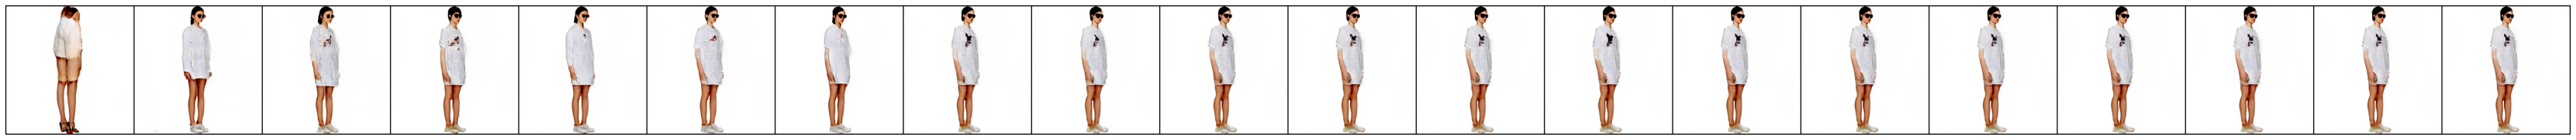

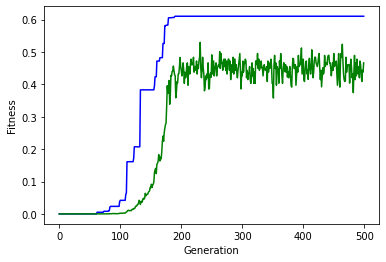

In [ ]:
#LOAD logbook and fitcollection before
steps = 70
gen = logbook.select("gen")
fit_max = logbook.chapters["fitness"].select("max")
fit_avg = logbook.chapters["fitness"].select("avg")
print(fit_max)

print("FITCOLLECTION IN STEPS:")
np.sort(np.asarray(fit_max), axis=0)[:5]
plt.figure(figsize = (60, 60))
plt.axis('off')
tens = torch.from_numpy(np.asarray(fitcollection))
genimgs = gan_model.test(tens[0:200:10].float(), getAvG=True)
plt.imshow(torchvision.utils.make_grid(genimgs, nrow=34).permute(1, 2, 0).cpu().numpy())
plt.show()

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_max, "b-", label="Maximum Fitness")
line2 = ax1.plot(gen, fit_avg, "g-", label="Average Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")
plt.show()

#FINAL POPULATION
#tens = torch.from_numpy(np.asarray(finalpop[::5]))
#genimgs = gan_model.test(tens.float(), getAvG=True)
#plt.figure(figsize=(20, 6), dpi=80)
#plt.imshow(torchvision.utils.make_grid(genimgs, nrow=34).permute(1, 2, 0).cpu().numpy())
#plt.show()

**Cluster Viz for comparison**

In [ ]:
#load embedding, ndices and images for plotting
with open('pose4-embedding-unique.pickle', 'rb') as handle:
  embedding = pickle.load(handle)
with open('pose4-index2-unique.pickle', 'rb') as handle:
  index_2 = pickle.load(handle)
  index_2 = np.asarray(index_2)
#load images for plotting
f = h5py.File('dataset/fashiongen_256_256_train.h5', 'r')
images = f['input_image']

228


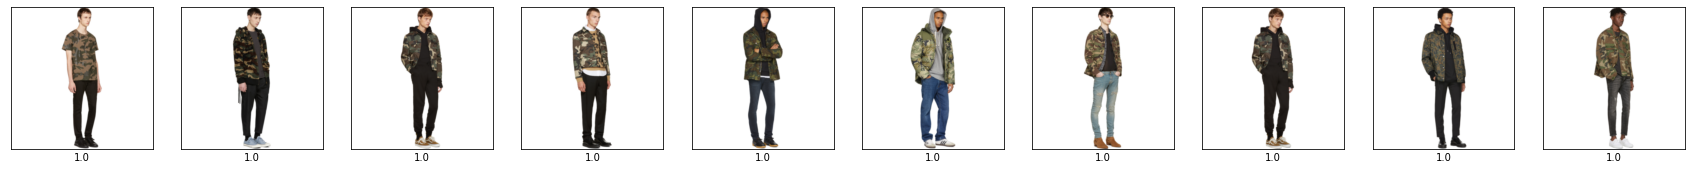

In [ ]:
n=10#np.count_nonzero(labels == TC)
i=TC
print(np.count_nonzero(labels == TC))

#choose closest n image indices to plot the images
image_ind = index_2[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]]]
best_distances = distances[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]],i]

plt.rcParams["figure.figsize"] = (30,3)
plt.subplots(1,n)
for j, ind in enumerate(image_ind):
  plt.subplot(1,n,j+1)
  plt.imshow(images[ind])
  ax = plt.gca()
  ax.axes.xaxis.set_ticks([])
  ax.axes.yaxis.set_ticks([])
  ax.set_xlabel(np.round(best_distances[j], decimals = 3))

**Random sampling**

In [ ]:
def random_sampling(NGEN, NPOP, TC):
  '''
  SET UP THE TOOLBOX
  '''
  toolbox = base.Toolbox()

  #POPULATION
  IND_SIZE = 532 #length of latent vectors + 20 placeholders required by the model
  creator.create("FitnessMax", base.Fitness, weights=(1.0,)) #maximizing objective
  creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)
  toolbox.register("attr_float", random.gauss, mu=0, sigma=1) #like the GAN's latent variables
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  #The fitness of an individual
  def evaluateInd(individual):
    #add the 20 extra latent variables to latent vector
    #new = torch.cat((torch.from_numpy(individual).unsqueeze(0), torch.from_numpy(np.zeros((1,20)))), 1)
    new = torch.from_numpy(individual).unsqueeze(0)
    #generate the image
    genimage = gan_model.test(new.float(), getAvG=True)
    #get its penultimate embedding
    embedding = extractembedding(genimage)
    #find its posterior probability of belonging to the target cluster after PCA
    #norm_embedding = normalizer.transform((embedding.numpy()).reshape(1,-1))
    scaled_embedding = scaler.transform((embedding.numpy()).reshape(1,-1))
    proj_embedding = pca_model.transform(scaled_embedding)
    target_proba = clustering_model.predict_proba(proj_embedding)[0,TC]
    return target_proba, #fitness weights should be in tuples

  toolbox.register("evaluate", evaluateInd)

  #initialize population and evaluate fitness
  population = toolbox.population(NGEN*NPOP)
  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

  fittest_individual = toolbox.clone(tools.selBest(population, 1))
  fittest = np.asarray(fittest_individual)
  fittest_tensor = torch.from_numpy(fittest)
  fittest_tensor = (fittest_tensor.unsqueeze(0)).unsqueeze(0)
  fittest_ever = gan_model.test(fittest_tensor.float(), getAvG=True)
  fitness_ever = fittest_individual[0].fitness.values[0]
  return fittest_ever, fitness_ever
random_sampling(10,15,0)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


(tensor([[[[1.0650, 1.0315, 0.9934,  ..., 1.0046, 0.9980, 1.1015],
           [1.0017, 0.9888, 0.9989,  ..., 0.9899, 1.0128, 0.9575],
           [0.9883, 0.9997, 1.0038,  ..., 0.9937, 1.0000, 0.9831],
           ...,
           [0.9969, 1.0035, 0.9983,  ..., 0.9946, 0.9833, 1.0119],
           [0.9610, 1.0098, 1.0004,  ..., 0.9857, 0.9577, 1.0108],
           [0.9804, 0.9674, 1.0180,  ..., 1.0191, 1.0272, 1.0454]],
 
          [[0.9864, 1.0586, 1.0022,  ..., 1.0086, 1.0008, 1.1805],
           [1.0119, 0.9997, 0.9992,  ..., 0.9938, 0.9993, 0.9664],
           [0.9920, 1.0032, 1.0023,  ..., 0.9967, 1.0009, 0.9839],
           ...,
           [1.0008, 0.9998, 0.9975,  ..., 0.9949, 0.9811, 1.0100],
           [0.9662, 1.0050, 1.0022,  ..., 0.9773, 0.9536, 1.0117],
           [1.0428, 0.9590, 1.0070,  ..., 1.0152, 1.0347, 0.9815]],
 
          [[1.0021, 1.0430, 0.9956,  ..., 1.0060, 0.9852, 1.1459],
           [0.9932, 0.9962, 0.9974,  ..., 0.9915, 1.0032, 0.9292],
           [0.9919, 1.00

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


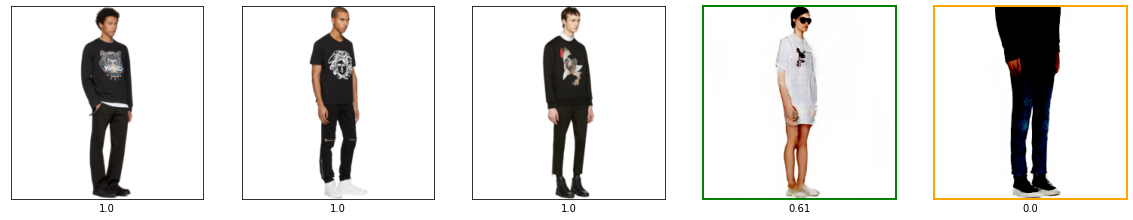

In [ ]:
#CLUSTER REFERENCE
n = 3
i = TC
image_ind = index_2[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]]]
best_distances = distances[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]],i]
#cluster_img = images[image_ind[:5]]
cluster_fit = best_distances[:n]

#FITTEST FROM RRUN
fit_max = logbook.chapters["fitness"].select("max")
tens = torch.from_numpy(np.asarray(fitcollection[-1]))
genimgs = gan_model.test(tens.float().unsqueeze(0), getAvG=True)
generated_img = torchvision.utils.make_grid(genimgs, nrow=34).permute(1, 2, 0).cpu().numpy()
generated_fit = fit_max[-1]

#RANDOM COMPARISON
random_vec, random_fit = random_sampling(NGEN,NPOP,TC)#(NGEN,NPOP,TC)
random_img = torchvision.utils.make_grid(random_vec, nrow=34).permute(1, 2, 0).cpu().numpy()

fig = plt.figure(figsize = (20, 20))
#for i in range(n):
plt.subplot(1,5,1)
plt.imshow(images[image_ind[0]])
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel(np.round(cluster_fit[0], decimals = 3))

plt.subplot(1,5,2)
plt.imshow(images[image_ind[1]])
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel(np.round(cluster_fit[1], decimals = 3))

plt.subplot(1,5,3)
plt.imshow(images[image_ind[2]])
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel(np.round(cluster_fit[2], decimals = 3))

plt.subplot(1,5,4)
plt.imshow(generated_img)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel(np.round(*generated_fit, decimals = 3))
color = "green"
ax.spines["top"].set_linewidth(2)
ax.spines["top"].set_color(color)
ax.spines["left"].set_linewidth(2)
ax.spines["left"].set_color(color)
ax.spines["right"].set_linewidth(2)
ax.spines["right"].set_color(color)
ax.spines["bottom"].set_linewidth(2)
ax.spines["bottom"].set_color(color)

plt.subplot(1,5,5)
plt.imshow(random_img)
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel(np.round(random_fit, decimals = 3))
color = "orange"
ax.spines["top"].set_linewidth(2)
ax.spines["top"].set_color(color)
ax.spines["left"].set_linewidth(2)
ax.spines["left"].set_color(color)
ax.spines["right"].set_linewidth(2)
ax.spines["right"].set_color(color)
ax.spines["bottom"].set_linewidth(2)
ax.spines["bottom"].set_color(color)

plt.show()
fig.savefig('results/imgs/result_cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=100)

Produce images for all runs

In [ ]:
CXPBS = [0.7, 0.9]
MUTPBS = [0.2, 0.5]
NGEN = 500
POPS = [100, 200]
TOURS = [3, 6]
TARGS = [48, 65, 96, 11, 138]
NELITE = 1
NNEW = 5
SIGMA = False
NOTE = "run1"

best = np.empty((len(CXPBS), len(MUTPBS), len(POPS), len(TOURS), len(TARGS)))

for cx, CXPB in enumerate(CXPBS):
  for mut, MUTPB in enumerate(MUTPBS):
    for npo, NPOP in enumerate(POPS):
      for tz, NTOUR in enumerate(TOURS):
        for tk, TC in enumerate(TARGS):

          #OPEN LOGBOOK
          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-logbook.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
            logbook = pickle.load(handle)
          fit_max = logbook.chapters["fitness"].select("max")
          best[cx, mut, npo, tz, tk] = max(fit_max)

          with open('results/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}nelite{}nnew{}sigma{}{}-fitcollection.pickle'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, NELITE, NNEW, SIGMA, NOTE), 'rb') as handle:
            fitcollection = pickle.load(handle)

          print(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC, best[cx, mut, npo, tz, tk])
          
          #CLUSTER REFERENCE
          n = 1
          i = TC
          image_ind = index_2[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]]]
          best_distances = distances[np.where(labels==i)[0][np.argsort(-1*distances[np.where(labels==i)[0], i])[:n]],i]
          cluster_img = images[image_ind[0]]
          cluster_fit = best_distances[0]

          #FITTEST FROM RRUN
          fit_max = logbook.chapters["fitness"].select("max")
          tens = torch.from_numpy(np.asarray(fitcollection[-1]))
          genimgs = gan_model.test(tens.float().unsqueeze(0), getAvG=True)
          generated_img = torchvision.utils.make_grid(genimgs, nrow=34).permute(1, 2, 0).cpu().numpy()
          generated_fit = fit_max[-1]

          fig = plt.figure()
          plt.subplot(1,2,1)
          plt.imshow(cluster_img)
          ax = plt.gca()
          ax.axes.xaxis.set_ticks([])
          ax.axes.yaxis.set_ticks([])
          ax.set_xlabel(np.round(cluster_fit, decimals = 3))

          plt.subplot(1,2,2)
          plt.imshow(generated_img)
          ax = plt.gca()
          ax.axes.xaxis.set_ticks([])
          ax.axes.yaxis.set_ticks([])
          ax.set_xlabel(np.round(*generated_fit, decimals = 3))

          plt.show()
          fig.savefig('results/imgs/cxpb{}mutpb{}ngen{}npop{}ntour{}tc{}IMG.png'.format(CXPB, MUTPB, NGEN, NPOP, NTOUR, TC), dpi=500)


#**References**
Grabe, I.: Evolutionary Search for Fashion Styles in the Latent Space of Generative Adversarial Networks. Master’s thesis, University of Copenhagen (2021)

Rostamzadeh, N., Hosseini, S., Boquet, T., Stokowiec, W., Zhang, Y., Jauvin, C., Pal, C.: Fashion-Gen: The Generative Fashion Dataset and Challenge. arXiv preprint arXiv:1806.08317 (2018)



#**Citation**
--------
If you use our code for your research, please cite:
```bibtex
@inproceedings{grabe_fashion_2022,
	title = {Fashion {Style} {Generation}: {Evolutionary} {Search} with {Gaussian} {Mixture} {Models} in the {Latent} {Space}},
	booktitle = {International {Conference} on {Computational} {Intelligence} in {Music}, {Sound}, {Art} and {Design} : {EvoMUSART} 2022},
	author = {Grabe, Imke and Zhu, Jichen and Agirrezabal, Manex},
	year = {2022},
	pages = {16},
}
```

